<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<b>Using the image cutout tool with DP0.2</b> <br>
Contact author(s): <i>Christina Williams</i> <br>
Last verified to run: <i>2024-1-9</i> <br>
LSST Science Piplines version: Weekly <i>2023_47</i> <br>
Container Size: <i>medium</i> <br>
Targeted learning level: <i>beginner</i> <br>

In [1]:
#%load_ext pycodestyle_magic
#%flake8_on
#import logging
#logging.getLogger("flake8").setLevel(logging.FATAL)

**Description:** This notebook demonstrates how to use the Rubin Image Cutout Service.

**Skills:** Run the Rubin Image Cutout Service for visual inspection of small cutouts of LSST images.

**LSST Data Products:** Images (deepCoadd, calexp), catalogs (objectTable, diaObject, truthTables, ivoa.ObsCore).

**Packages:** PyVO, lsst.rsp.get_tap_service, lsst.rsp.retrieve_query, lsst.pipe.tasks.registerImage, lsst.afw.display

**Credit:**
This notebook builds on tutorial notebook DP0.2 22a demonstrating the technical background for the cutout service developed by Leanne Guy, and builds on an earlier notebook written by Alex Drlica-Wagner <a href="https://github.com/rubin-dp0/cst-dev/blob/main/ADW_gravelpit/TAP_Image_Access.ipynb">linked here</a>. This notebook additionally includes contributed functions by Jeff Carlin and Ryan Lau for time-variable sources. 

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook will teach how to use the cutout service (which enables users to retrieve small image cutouts from LSST data) by demonstration of a few basic science applications. Since LSST images are quite large, in some cases it is desirable to be able to perform operations (e.g. image cutouts) on the server side to avoid transferring large amounts of data. This can speed up visual inspection and other analyses requiring images of individual objects or fields that may be much smaller than the patch and tract sizes that are created by the LSST camera and pipelines.

The International Virtual Observatory Alliance (IVOA) provides a Server-side Operations for Data Access (SODA) for web data access. The LSST architecture is built to fit into the requirements of the Virtual Observatory, enabling the use of Virtual Observatory tools such as the image cutout service to access LSST data. The procedure is to identify the remote web location of the image of interest (called a datalink), and use a web service that creates a cutout from that linked data remotely, to transfer and save locally on the Rubin Science Platform.

Further demonstration of the technical side of this process using DP0.2 data can be found in (Leanne's companion tutorial when published, link here). Further details and information can be found at <a href="https://www.ivoa.net/documents/DataLink/20211115/WD-DataLink-1.1-20211115.html"> the IVOA data link documentation</a>, where it says Access Data Services. Rubin-specific documentation for these can also be found in <a href="https://dmtn-238.lsst.io/">this document describing the RSP DataLink service implementation strategy</a>. 



### 1.1 Package Imports


In [2]:
# LSST package for Butler queries
import lsst.daf.butler as dafButler

# LSST package for image display
import lsst.afw.display as afwDisplay

# Import general python packages
import time
import numpy as np
import re
import uuid
import requests
import warnings
import matplotlib.pyplot as plt
import os
import glob

# Science Pipelines imports
from lsst.daf.butler import Butler, DatasetType, CollectionType
import lsst.geom as geom
import lsst.resources
import lsst.afw.image as afwImage
from lsst.afw.image import Image, ImageF
from lsst.afw.image import Exposure, ExposureF

# Pandas tools for working with tables
import pandas
from pandas.testing import assert_frame_equal

# Plotting functions
import matplotlib.pyplot as plt

# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service, retrieve_query
from lsst.rsp.utils import get_access_token

# PyVO packages
import pyvo
from pyvo.dal.adhoc import DatalinkResults, SodaQuery

# Astropy
from astropy import units as u
from astropy.units import UnitsWarning
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.time import Time
from astropy.utils.data import download_file
from astropy.visualization import  ZScaleInterval, AsinhStretch
from astropy.wcs import WCS       
from astropy.visualization import simple_norm, imshow_norm
from astropy.visualization import ImageNormalize
from astropy.visualization.stretch import SinhStretch, LinearStretch, SqrtStretch

# Packages for warping and aligning calexp cutouts
from lsst.pipe.tasks.registerImage import RegisterConfig, RegisterTask
from PIL import Image


### 1.2 Define Functions and Parameters


#### 1.2.1 Set up  plotting defaults for matplotlib.

In [3]:
# Set up some plotting defaults
params = {'axes.labelsize': 18,
          'font.size': 18,
          'legend.fontsize': 12,
          'xtick.major.width': 2,
          'xtick.minor.width': 1,
          'xtick.major.size': 10,
          'xtick.minor.size': 4,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 2,
          'axes.linewidth': 2,
          'axes.labelweight': 2,
          'axes.titleweight': 2,
          'ytick.major.width': 2,
          'ytick.minor.width': 1,
          'ytick.major.size': 10,
          'ytick.minor.size': 4,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [6, 6],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

# Set afw display backend to matplotlib
afwDisplay.setDefaultBackend('matplotlib')

# Set the maximum number of rows to display from pandas
pandas.set_option('display.max_rows', 20)

plt.style.use('tableau-colorblind10')


#### 1.2.2 Create some environment variables

This next cell creates a new temporary folder in the home directory called "temp". The cutout tool must first save cutouts as fits files locally on the Rubin Science Platform (RSP) so this notebook will save those files in temp. At the end of the notebook, the last cell will clear the contents and remove the temp folder.

In [4]:
homeDir = os.getenv("HOME")
tempdir = homeDir+'/temp'
if not os.path.exists(tempdir):
    os.makedirs(tempdir)


#### 1.2.3 Define functions for manipulating image cutouts and plotting

The following cells define a number of functions to be used throughout the tutorial. The first function is to enable easy plotting of files from the cutout tool (plotImage). The next function, `make_image_cutout', is a wrapper function that will perform the operations needed to call the cutout tool and create image cutouts stored locally. This procedure will first be demonstrated in Section 1. The steps include: 1) define the location on the sky. 2) Query the TAP service for the specifications of the dataId. 3) Retrieve the datalink URL associated with the data. 4) Create a cutout(?) instance from the query result and the Datalink Resource (cutout service? cutout-sync?).

In [5]:
def plotImage(exposure: ExposureF, img_opt: dict = None):
    """Plot and image using matplotlib
   
   Parameters
    ----------
    image : `Exposure`
        the image to plot
        
    opts : ``
   
   Returns
    -------
    title : `str` (only if result is not `None`)
        Plot title from string
    """
    
    fig, ax = plt.subplots()
    display = afwDisplay.Display(frame=fig)
    display.scale('asinh', 'zscale')
    display.mtv(exposure.image)
    plt.show()


In [6]:
def make_image_cutout(tap_service, ra, dec, cutout_size=0.01, 
                      imtype=None, dataId=None, filename=None): #visit=None, detector=None, filename=None):
    """Make a cutout using the cutout tool
   
   Parameters
    ----------
    # cutout_size is in degrees
    # if imtype None, assumes deepCoadd. dataId must correspond to that for provided imtype
    # get difference images too (i.e. new, reference/template, and difference image). might want to 
    # (not in this function but down the road in our package of utilities to have triplet)
    # tutorial should demonstrate volume of cutouts (i.e. what i am already doing)
   Returns
    -------
    
    """

    spherePoint = geom.SpherePoint(ra*geom.degrees, dec*geom.degrees)
    
    if imtype == 'calexp':
        
        query = "SELECT access_format, access_url, dataproduct_subtype, lsst_visit, lsst_detector, " + \
            "lsst_band, s_ra, s_dec FROM ivoa.ObsCore WHERE dataproduct_type = 'image' " + \
            "AND obs_collection = 'LSST.DP02' " + \
            "AND dataproduct_subtype = 'lsst.calexp' " + \
            "AND lsst_visit = " + str(dataId["visit"]) + " " + \
            "AND lsst_detector = " + str(dataId["detector"])
        results = tap_service.search(query)

    else:
        # Find the tract and patch that contain this point
        # this is how its done using butler:
        tract = dataId["tract"]
        patch = dataId["patch"]
        
        # add optional default band if it is not contained in the dataId
        band = dataId["band"]

        query = "SELECT access_format, access_url, dataproduct_subtype, lsst_patch, lsst_tract, " + \
            "lsst_band, s_ra, s_dec FROM ivoa.ObsCore WHERE dataproduct_type = 'image' " + \
            "AND obs_collection = 'LSST.DP02' " + \
            "AND dataproduct_subtype = 'lsst.deepCoadd_calexp' " + \
            "AND lsst_tract = " + str(tract) + " " + \
            "AND lsst_patch = " + str(patch) + " " + \
            "AND lsst_band = " + "'" + str(band) + "' "
        results = tap_service.search(query) 

    #Get datalink
    dataLinkUrl = results[0].getdataurl()
    f"Datalink link service url: {dataLinkUrl}"
    auth_session = service._session
    dl_results = DatalinkResults.from_result_url(dataLinkUrl,session=auth_session)
    f"{dl_results.status}"

    # from_resource: creates a instance from a number of records and a Datalink Resource.
    sq = SodaQuery.from_resource(dl_results, dl_results.get_adhocservice_by_id("cutout-sync"), 
                                 session=auth_session)

    sq.circle = (spherePoint.getRa().asDegrees()* u.deg,
                 spherePoint.getDec().asDegrees()*u.deg, 
                 cutout_size* u.deg)

    if filename:
        sodaCutout = os.path.join(os.getenv('HOME'), 'temp/'+filename)
    else:
        sodaCutout = os.path.join(os.getenv('HOME'), 'temp/soda-cutout.fits')

    with open(sodaCutout, 'bw') as f:
        f.write(sq.execute_stream().read())
        
    return sodaCutout


Finally, this third cell below defines a set of functions that we will use to work with cutouts of the same source to demonstrate how to visualize variability between calExp files, for diaObjects. Since calExp files may be imaged at any orientation on the sky, in order to align the images the user will 1) rotate and scale the image to a common grid (warp_image) and 2) determine the bounding box of the cutouts (get_minmax_xy) and 3) create a gif of those warped images to visualize the variability of the source (make_gif). These will be demonstrated in Section 4.

In [7]:
def warp_img(ref_img, img_to_warp, ref_wcs, wcs_to_warp):

    config = RegisterConfig()
    task = RegisterTask(name="register", config=config)
    warpedExp = task.warpExposure(img_to_warp, wcs_to_warp, ref_wcs,
                                  ref_img.getBBox())

    return warpedExp

def get_minmax_xy(img, cutout_size):

    cutout_size = int(cutout_size)
    
    height = img.height
    width = img.width

    ceny = (height - 1) / 2
    cenx = (width - 1) / 2

    minx = int(cenx - ((cutout_size - 1) / 2))
    maxx = int(cenx + ((cutout_size - 1) / 2))
    miny = int(ceny - ((cutout_size - 1) / 2))
    maxy = int(ceny + ((cutout_size - 1) / 2))

    return {'minx':minx, 'maxx':maxx, 'miny':miny, 'maxy':maxy}

def make_gif(frame_folder):
    frames = [Image.open(img) for img in sorted(glob.glob(f"{frame_folder}/*.png"))]
    frame_one = frames[0]
    frame_one.save(frame_folder+"/animation.gif", format="GIF", append_images=frames,
               save_all=True, duration=500, loop=1)


## 2. A step by step demonstration of how to use the Rubin Image Cutout Service

This section will demonstrate a simple example: how to create a cutout for a single object from a deepCoadd. 


### 2.1 Initiate Butler and TAP, and define sky coordinates for the image cutout

Both the Butler and the TAP service are needed. The Butler is needed to identify which deepCoadd image hosts the object of interest. The TAP service is then used to query the ivoa.Obscore table for the datalink (a web URL identifying where the data is hosted).

In [8]:
butler = Butler('dp02', collections='2.2i/runs/DP0.2')
registry = butler.registry


In [9]:
service = get_tap_service()

/tmp/ipykernel_1748/1920553455.py:1: DeprecationWarning: get_tap_service() is deprecated, use get_tap_service("tap")
  service = get_tap_service()


First, define a point on the sky as the center of the image cutout. This example uses the galaxy cluster from DP0.3 Notebook Tutorial 03a. Once the RA and Dec are defined, we will create a SpherePoint class to define the location on the sky, that is then used to identify which Patch and Tract contains that location among the deepCoadd images.  

In [10]:
ra = 55.7467 
dec = -32.2862

spherePoint = lsst.geom.SpherePoint(ra*geom.degrees, dec*geom.degrees)

# Find the tract and patch that contain this point
skymap = butler.get('skyMap') # skymap is used for coadd projection
tract = skymap.findTract(spherePoint)
patch = tract.findPatch(spherePoint)


The identified Patch and Tract will be used to define the unique dataId for that location, and once a filter (band) is included, this defines a unique deepCoadd in the LSST image database. 

In [11]:
dataId = {'band':'i', 'tract':tract.tract_id, 'patch': patch.getSequentialIndex()}

# And use the dataid to get the coadd
deepCoadd = butler.get('deepCoadd_calexp', dataId=dataId)

assert type(deepCoadd) == lsst.afw.image.ExposureF
f"Tract: {tract.tract_id}, Patch: {patch.getSequentialIndex()}"



'Tract: 4431, Patch: 17'

The next cell shows the query to the TAP service for the metadata that is associated with the image's remote location in the LSST data archive. The DP0.2 has a schema (table collection) called "ivoa", which contains a table called ivoa.ObsCore. The IVOA-defined obscore table contains generic metadata for the DP0.2 datasets, which are held at the Interim Data Facility (IDF; hosted by Google Cloud, see <a href="https://www.lsst.org/news/rubin-observatory-will-partner-google-cloud-host-interim-data-facility">this link for more information</a>). The table is accessible via ADQL queries via a TAP endpoint. The mechanism for locating images from observations is to use the TAP service to query the ObsCore schema. 

In [12]:
t = tract.tract_id
p = patch.getSequentialIndex()

print(tract.tract_id, patch.getSequentialIndex())

query = "SELECT access_format, access_url, dataproduct_subtype, lsst_patch, lsst_tract, " + \
    "lsst_band, s_ra, s_dec FROM ivoa.ObsCore WHERE dataproduct_type = 'image' " + \
    "AND obs_collection = 'LSST.DP02' " + \
    "AND dataproduct_subtype = 'lsst.deepCoadd_calexp' " + \
    "AND lsst_tract = " + str(t) + " " + \
    "AND lsst_patch = " + str(p) + " " + \
    "AND lsst_band = 'i' "
    
results = service.search(query)
results.to_table().show_in_notebook()

4431 17


idx,access_format,access_url,dataproduct_subtype,lsst_patch,lsst_tract,lsst_band,s_ra,s_dec
,,,,,,,deg,deg
0,application/x-votable+xml;content=datalink,https://data.lsst.cloud/api/datalink/links?ID=butler%3A//dp02/20d28216-534a-4102-b8a7-1c7f32a9b78c,lsst.deepCoadd_calexp,17,4431,i,55.65214108466622,-32.205663176664345


In the above table, the access_url contains the web URL datalink for the requested deepCoadd. This datalink will be needed to generate the image cutout.

### 2.2 Generating an image cutout 

First, extract the datalink (`dataLinkUrl`) from the query result using the `getdataurl` method. Next, extract the session authentication, which is needed for reuse of the datalink (see DP0.2 Tutorial 22a, which has further technical explanation). Finally, create a `DatalinkResults` object to be able to access this URL, which will be stored as `dl_results`, in a format that can be used by the IVOA tools below.


In [13]:
dataLinkUrl = results[0].getdataurl()
f"Datalink link service url: {dataLinkUrl}"
auth_session = service._session
dl_results = DatalinkResults.from_result_url(dataLinkUrl,session=auth_session)
f"{dl_results.status}"

"('OK', 'QUERY_STATUS not specified')"

Lastly, call the Rubin Image Cutout Service. It is done by feeding the data link created above (called `dl_results`) to following function:

In [14]:
sq = SodaQuery.from_resource(dl_results, dl_results.get_adhocservice_by_id("cutout-sync"), 
                             session=auth_session)


The variable `sq` now holds the result of the SODA query using the data link (which currently still points the full LSST patch and tract deepCoadd image, at its remote location in the database). The cell below will now demonstrate how to extract a cutout from `sq`.  

### 2.2.1 Defining a square cutout using a subtended circle

Only 2 shape definitions are supported: a circle or a polygon can be used to define the cutout dimensions. In the case of circle, the resulting cutout is a square (with edge size that is the same as the circle diameter). In the case of a polygon, either a square or a rectanglar cutout will result, depending on the edge dimensions.

For now, while the image cutout procedure is performed remotely, the cutout must be written to disk first before it is accessed by the notebook (which is done using the write() function). All cutouts will be stored in the $HOME/temp folder. Finally, call the plotImage function (defined above), which will quickly display the cutout that was written to disk in in the temp folder.

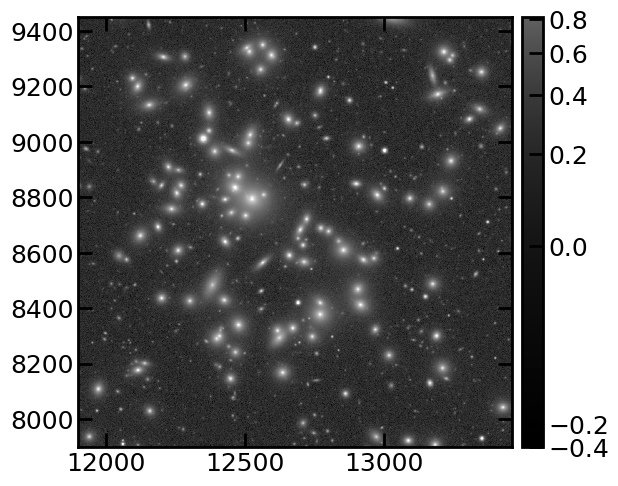

In [15]:

sphereRadius = 0.05* u.deg

sq.circle = (spherePoint.getRa().asDegrees()* u.deg,
             spherePoint.getDec().asDegrees()*u.deg, 
             sphereRadius)

# first write the file to disk:
sodaCutout = os.path.join(os.getenv('HOME'), 'temp/soda-cutout.fits')
with open(sodaCutout, 'bw') as f:
    f.write(sq.execute_stream().read())
    
# Display the cutout from the file
plotImage(ExposureF(sodaCutout))


### 2.2.2 Using polygon to define the image cutout shape instead of a circle

It is also possible to define the cutout geometry using a polygon, which enables the cutout to be rectangular, but not necessarily be square. For this, use `polygon', which takes as input the four corners in celestial coordinates. For example: a polygon is defined as a set of 4 (x,y) coordinates from (12,34) to (14,34) to (14,36) to (12,36) and (implicitly) back to (12,34) as:

POLYGON=12 34 14 34 14 36 12 36

Since the center of the galaxy cluster is already defined in RA and Dec in the cells above (`spherePoint`), this example will define each x,y set as RA+/-sphereRadius and Dec+/-sphereRadius. 

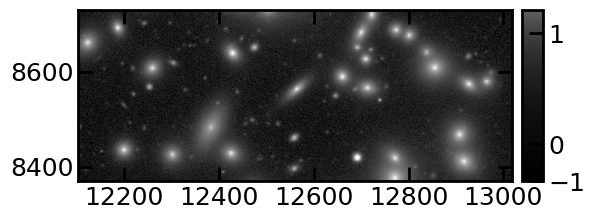

In [16]:
#Alternatively can use polygon to define a region. Actually, circle is easier because there's less to define
#and it looks like "radius" is also half of the box edge. Here's a demonstration using polygon.

sq2 = SodaQuery.from_resource(dl_results, dl_results.get_adhocservice_by_id("cutout-sync"), 
                             session=auth_session)
sphereRadius1 = 0.03* u.deg
sphereRadius2 = 0.01* u.deg

sq2.polygon = (spherePoint.getRa().asDegrees()* u.deg - sphereRadius1,
              spherePoint.getDec().asDegrees()*u.deg - sphereRadius2,
              spherePoint.getRa().asDegrees()* u.deg - sphereRadius1,
              spherePoint.getDec().asDegrees()*u.deg + sphereRadius2,
              spherePoint.getRa().asDegrees()* u.deg + sphereRadius1,
              spherePoint.getDec().asDegrees()*u.deg + sphereRadius2)
              #spherePoint.getRa().asDegrees()* u.deg + sphereRadius2,
              #spherePoint.getDec().asDegrees()*u.deg - sphereRadius2)


sodaCutout2 = os.path.join(os.getenv('HOME'), 'temp/soda-cutout.fits')
with open(sodaCutout2, 'bw') as f:
    f.write(sq2.execute_stream().read())

plotImage(ExposureF(sodaCutout2))



### 2.3 Test out the cutout wrapper function "make_image_cutout" 

All of the above steps from section 2.2 have been compiled in a wrapper function called `make_image_cutout` that is defined in Section 1. In the rest of this notebook, cutouts will be generated using this function for simplicity. As defined, it assumes the circular cutout definition demonstrated above. Thus, the function requires as input the TAP service, the center ra/dec of the cutout, the `dataId` and imtype (Section 4 will demonstrate how to do this for calexp, not just deepCoadd) and the size of the cutout (i.e. what was defined as sphereRadius above). The next cell demonstrates how to run all the steps by calling `make_image_cutout` and plotting the result.

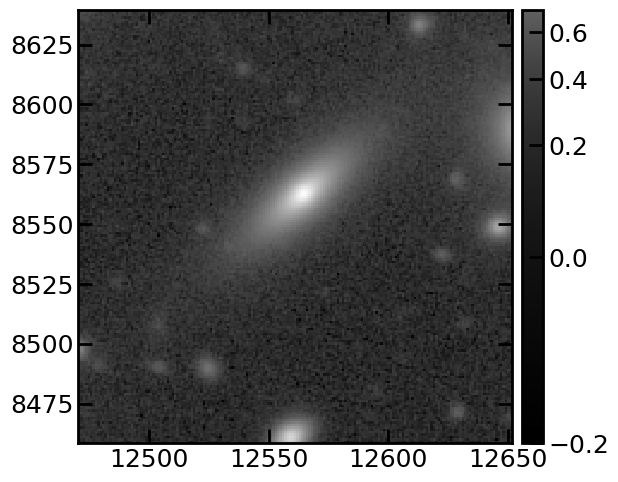

In [17]:
imtype = 'deepCoadd'
test = make_image_cutout(service, ra, dec, dataId=dataId, imtype=imtype, cutout_size=0.005)
plotImage(ExposureF(test))


## 3. Science application: validating a galaxy sample based on color-color selection 

This section will demonstrate a simple example of a science use-case for the Rubin Image Cutout Service. Lyman-break color selections are a common way to identify galaxies at high redshifts. The selections make use of the absorption by intergalactic hydrogen in the foreground of all galaxy light blueward of the Lyman limit (912A) or at very high redshifts, Lyman-alpha (1216A). DP0.2 includes mock galaxies up to redshift (z) of 3, where the Lyman-break falls between the LSST u and g bands. Such galaxies can be identified by their very red u-g colors, and since intergalactic hydrogen absorbs all the light blueward of the Lyman break, true z~3 galaxies should be undetected in the LSST u-band. The cell below will perform a search for redshift of 3 galaxies as u-band dropouts, and will create cutouts in each of the LSST filters in order to visually inspect the Lyman-break galaxy (LBG) candidates to confirm the real candidates show no u-band flux. 

### 3.1 The u-band dropout LBG color selection
To search for $z\sim3$ LBGs in DP0.2, first define a u-band color selection based on the existing literature that uses filter sets similar to that of LSST. Below outlines the set of colors used in Steidel et al. 2003 (see also Boutsia et al 2014, among other references. Many selections exist, where changes to colors would alter the redshift selection function, or may differ due to differences in the broad band filter shapes of other instruments).

U − G >= (G − R) + 1.0

G − R <= 1.2


where capital letters U, G, and R indicate the total AB magnitudes in the LSST filters u, g, r. Since DP0.2 is only 5-year depth mock data in the LSST filters, our search will also include a g-band magnitude that is relatively bright (G < 24.5 ABmag) in order to obtain high-quality candidates. 

High redshift galaxies are typically small in size. For this exercise, use aperture photometry with a relatively small aperture diameter (9 pixels) in order to obtain high S/N measurements and exclude neighbors.

#### 3.1.1 Ammending a typical search because of the rarity of z~3 galaxies in the mock data.
The mock galaxies that go into DP0.2 are created using the LSST Catalog Simulator (<a href=https://www.lsst.org/scientists/simulations/catsimcatSim>catSim</a>), and are based on an empirical model of the evolution of galaxies outlined in <a href="https://arxiv.org/abs/1907.06530">Korytov et al. 2019</a>. The input model is based on realistic number densities, fluxes, and redshift distributions across cosmic time, and utilizes the UniverseMachine methodology to assign empirical properties (see <a href="https://arxiv.org/abs/1806.07893">Behroozi et al. 2019</a>). 

Typically at any redshift, bright galaxies are rarer than faint galaxies, which are much more common. And typically in any patch of the sky, nearby galaxies will be much more common above the detection limit of a survey than distant $z\sim3$ galaxies. This means that $z\sim3$ galaxies that are bright enough to meet the criteria we want (G$ < 24.5$) will require a large search area to identify a statistical sample. So, in this example, we will first identify a parent sample of bright (G < 24.5) galaxies over a very large area (4 degrees) to ensure the parent sample contains enough rare distant galaxies.



In [18]:

max_rec = 5000
use_center_coords = "62, -37"
ralbg = 62.
declbg = -37.
use_radius = "4.0"

#query = "SELECT TOP " + str(max_rec) + " " + \
#        "mt.id_truth_type, mt.match_objectId, ts.ra, ts.dec, ts.truth_type, ts.redshift, "\
#        "obj.objectId, obj.coord_ra, obj.coord_dec, obj.detect_isPrimary, obj.patch, obj.tract, " + \
#        "obj.u_ap09Flux, scisql_nanojanskyToAbMag(obj.u_ap09Flux) as umag," + \
#        "scisql_nanojanskyToAbMag(obj.u_ap09FluxErr) as umagErr," + \
#        "scisql_nanojanskyToAbMag(obj.r_ap09Flux) as rmag, "\
#        "scisql_nanojanskyToAbMag(obj.g_ap09Flux) as gmag, " + \
#        "obj.u_ap09Flux/obj.u_ap09FluxErr as S2N "\
#        "FROM dp02_dc2_catalogs.MatchesTruth AS mt "\
#        "JOIN dp02_dc2_catalogs.TruthSummary AS ts ON mt.id_truth_type = ts.id_truth_type "\
#        "JOIN dp02_dc2_catalogs.Object AS obj ON mt.match_objectId = obj.objectId "\
#        "WHERE CONTAINS(POINT('ICRS', ts.ra, ts.dec),  "\
#        "CIRCLE('ICRS', " + use_center_coords + ", " + use_radius + ")) = 1 " + \
#        "AND obj.detect_isPrimary = 1 "\
#        "AND obj.detect_fromBlend = 0 "\
#        "AND ts.redshift > 2.9 " + \
#        "AND obj.g_ap09Flux/obj.g_ap09FluxErr > 10 " + \
#        "AND scisql_nanojanskyToAbMag(obj.g_ap09Flux) < 24.5 " 

#results = service.search(query)
##assert len(results) == max_rec
#results.to_table()


In [19]:
max_rec = 500000
query = "SELECT TOP " + str(max_rec) + " " + \
        "objectId, coord_ra, coord_dec, detect_isPrimary, patch, tract, " + \
        "u_ap09Flux, scisql_nanojanskyToAbMag(u_ap09Flux) as umag, scisql_nanojanskyToAbMag(r_ap09Flux) as rmag, " + \
        "scisql_nanojanskyToAbMag(g_ap09Flux) as gmag, " + \
        "scisql_nanojanskyToAbMag(u_ap09FluxErr) as umagErr," + \
        "u_ap09Flux/u_ap09FluxErr as ubandS2N "\
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS', " + use_center_coords + ", " + use_radius + ")) = 1 " + \
        "AND detect_isPrimary = 1 AND detect_fromBlend = 0 " + \
        "AND g_ap09Flux/g_ap09FluxErr > 10 AND r_ap09Flux/r_ap09FluxErr > 10" + \
        "AND scisql_nanojanskyToAbMag(g_ap09Flux) < 24.5 "

results = service.search(query)
#assert len(results) == max_rec
results.to_table()

objectId,coord_ra,coord_dec,detect_isPrimary,patch,tract,u_ap09Flux,umag,rmag,gmag,umagErr,ubandS2N
,deg,deg,,,,nJy,,,,,
int64,float64,float64,bool,int64,int64,float64,float64,float64,float64,float64,float64
1405791586809283127,60.4465925,-40.7900205,True,31,3261,1508.0021443,23.453995102304546,22.961225470604315,23.32954361724193,26.89326762170504,23.752482553023075
1405791586809283415,60.4246972,-40.7843474,True,31,3261,760.7822103,24.1968491281198,24.913913006128553,24.49577154007617,26.922396144473623,12.308887618310603
1405791586809282818,60.4006376,-40.7972744,True,31,3261,1476.2860402,23.477073717317484,23.580932298920914,23.501560295882523,26.897858218921932,23.35144717932817
1405791586809283990,60.2984402,-40.7713752,True,31,3261,2846.9143678,22.764063989448417,22.906417459445777,22.72145475065328,26.87845736410538,44.234115731021205
1405791586809283722,60.3696682,-40.7772683,True,31,3261,133.4709868,26.08653282155474,22.691273650820435,24.107468744483263,26.944465758165094,2.2038050537147793
1405791586809283670,60.3477601,-40.7786029,True,31,3261,1298.8083114,23.616137352194688,23.552849914329045,23.586751139618073,26.88820477314587,20.362306410016647
1405791586809283691,60.3588224,-40.7781139,True,31,3261,1203.5529866,23.698836962721572,22.19662856181774,23.130480076067993,26.909909066434523,19.24991612180353
1405791586809283829,60.3446909,-40.7752595,True,31,3261,576.8747835,24.49729611154967,24.458121516389795,24.45087236993394,26.904547703784203,9.181225133592347


The next cell will plot the U-G vs G-R colors of the parent sample, and identify the high-redshift galaxy candidates based on the color selection discussed above. For sources with low S/N fluxes in u-band, the U-G color can be overestimated if a very faint u-band flux is used (but is not significant). Thus, for sources with low S/N u-band flux we will reset it to an error floor that corresponds the noise level of the u-band imaging (in this case, we will use the umagErr from the object table).

Further, for this simple example we will restrict the color selection to be narrow and blue in G-R (G-R$<$0.2; this may exclude real z=3 galaxies that are redder in G-R, for example galaxies that have older stars or are dusty; but the restriction is helpful for this simple example because it lowers the number of interloper sources). The LBG candidates identified using the color selection (black dashed lines) are in orange, with the full query of all objects in blue.


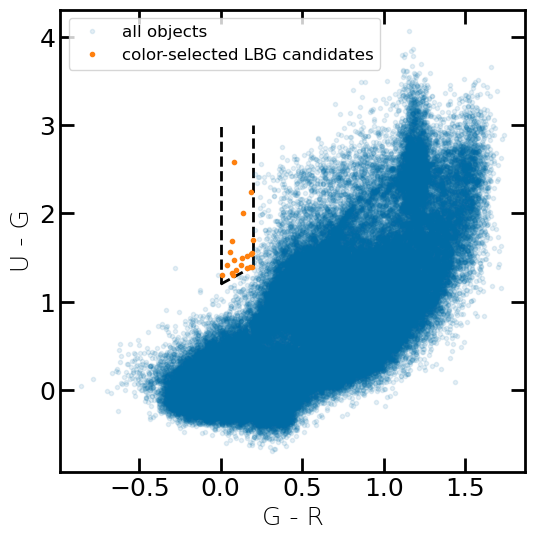

In [20]:

# here, set u-band magnitude to umag of 1-sig error before selecting colors
umag = np.zeros(len(results['umag']))
for i in range(len(umag)):

    whnondet = np.where(results['ubandS2N'][i] < 1)[0]
    if len(whnondet) > 0:
        umag[i] = results['umagErr'][i]
    else:
        umag[i] = results['umag'][i]


GRlim = 0.2 #1.2
GRfloor = 1.2 # 1.0
#whlbg = np.where(((umag-results['gmag']) >= ((results['gmag'] - results['rmag']) + GRfloor )) & 
#                 ((results['gmag'] - results['rmag']) < GRlim ) & 
#                 ((results['gmag'] - results['rmag']) > 0))[0]
whlbg = np.where(((umag-results['gmag']) >= ((results['gmag'] - results['rmag']) + GRfloor )) & 
                  ((results['gmag'] - results['rmag']) < GRlim ) & 
                  ((results['gmag'] - results['rmag']) > 0))[0]

# plot the color-color selection box:
GmR = np.arange(0,GRlim+.01,.1) 
plt.plot(GmR,GmR + GRfloor,'--', color='k')
plt.plot([0,0],[GRfloor,3],'--', color='k')
plt.plot([GRlim,GRlim],[GRlim+GRfloor,3],'--', color='k')


GminusR = results['gmag']-results['rmag']
UminusG = umag-results['gmag']


plt.plot(GminusR, UminusG, '.',label='all objects', alpha=.1)
plt.plot(GminusR[whlbg],UminusG[whlbg],'.', label='color-selected LBG candidates')

plt.xlabel('G - R')
plt.ylabel('U - G')
plt.legend()
plt.show()


Some fraction of the orange LBG candidates might be interlopers. The cell below will plot image cutouts of each LBG candidate for visual inspection. Since this is a simulated dataset, included in this cell is `query3` to the TAP service, which pulls the intrinsic redshift for each object from the truth table to compare with the expected redshift $z\sim3$ of selected objects (see DP0.2 Tutorial Notebook 08 for more information on truth tables). 

Due to the number of cutouts, this cell can take some time to run. Adjust the range of the for loop as needed to see the cutouts for the entire sample, rather than a subset of 5.

By inspecting the cutouts and intrinsic redshift, there are a small number of interlopers (at redshifts $z<2.5$ or so) which visibly show some u-band flux.

<Table length=1>
       gmag       mt_id_truth_type ...        S2N         ts_redshift
     float64           object      ...      float64         float32  
----------------- ---------------- ... ------------------ -----------
24.45746965947551     9706148291_1 ... 2.5139709008879128     2.83135


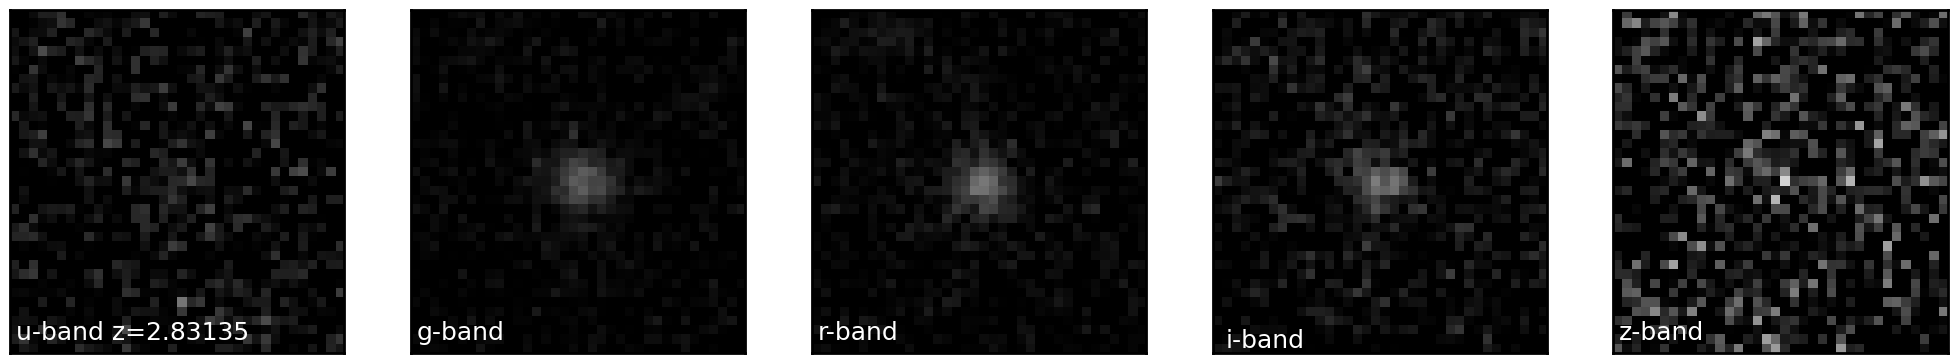

<Table length=1>
       gmag       mt_id_truth_type ...        S2N         ts_redshift
     float64           object      ...      float64         float32  
----------------- ---------------- ... ------------------ -----------
24.38429108999451     9762571970_1 ... 2.8776192119718225     1.98357


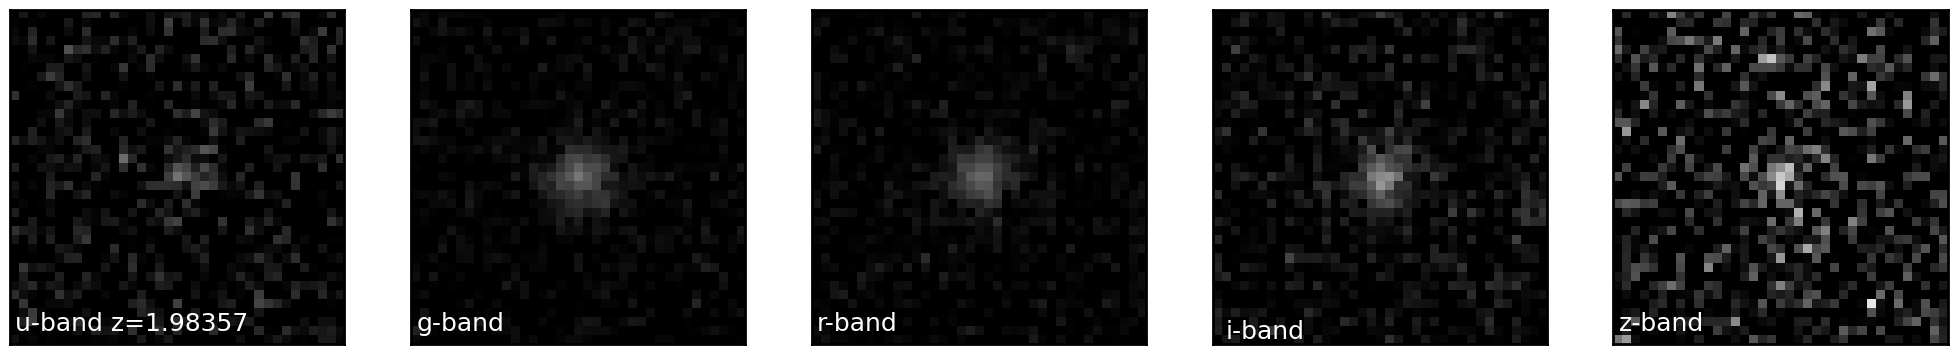

<Table length=1>
       gmag        mt_id_truth_type ...        S2N         ts_redshift
     float64            object      ...      float64         float32  
------------------ ---------------- ... ------------------ -----------
24.183287735345562     7957723427_1 ... 3.1358794148208626     2.97819


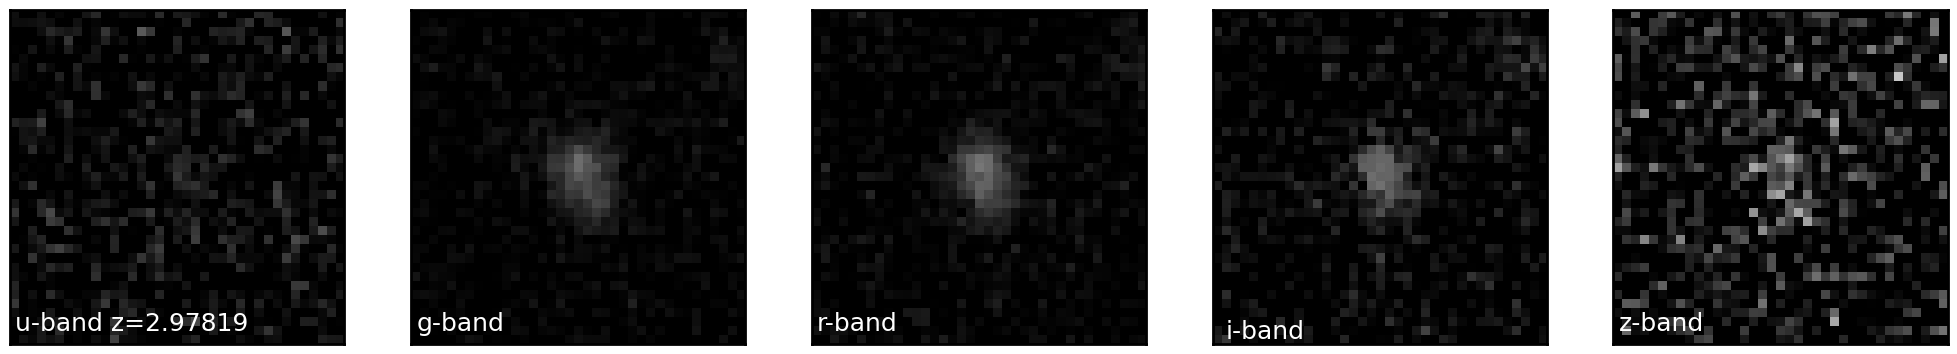

<Table length=1>
       gmag       mt_id_truth_type ...        S2N         ts_redshift
     float64           object      ...      float64         float32  
----------------- ---------------- ... ------------------ -----------
24.23484993985894     8769504807_1 ... 0.9440272314782314     2.91797


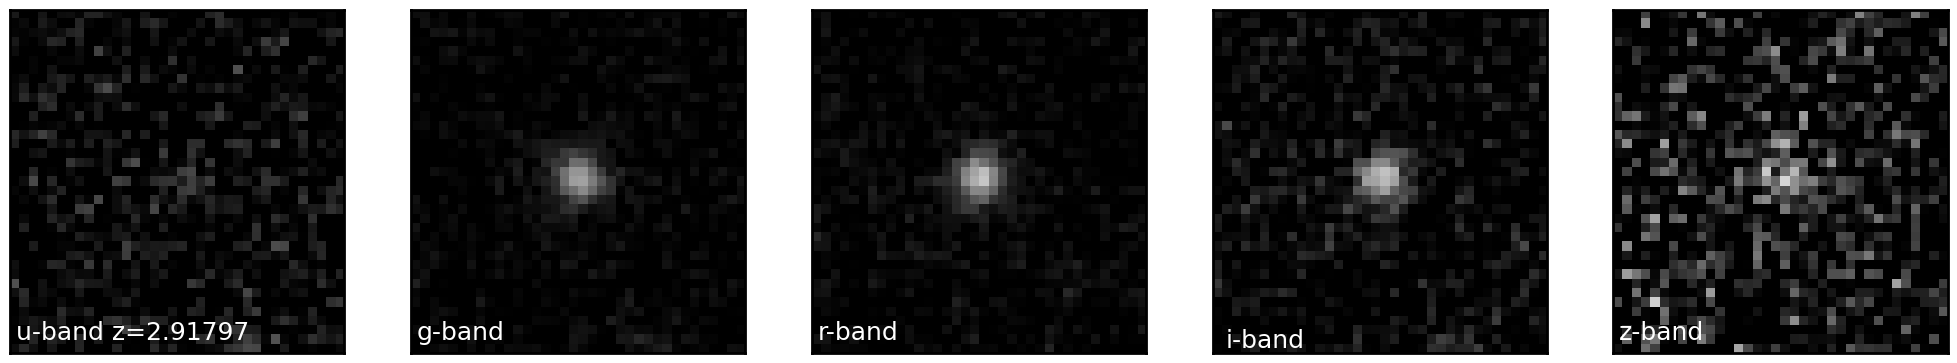

<Table length=1>
       gmag       mt_id_truth_type ...        S2N        ts_redshift
     float64           object      ...      float64        float32  
----------------- ---------------- ... ----------------- -----------
24.08185834082325     8769499238_1 ... 3.364039375796062      2.9079


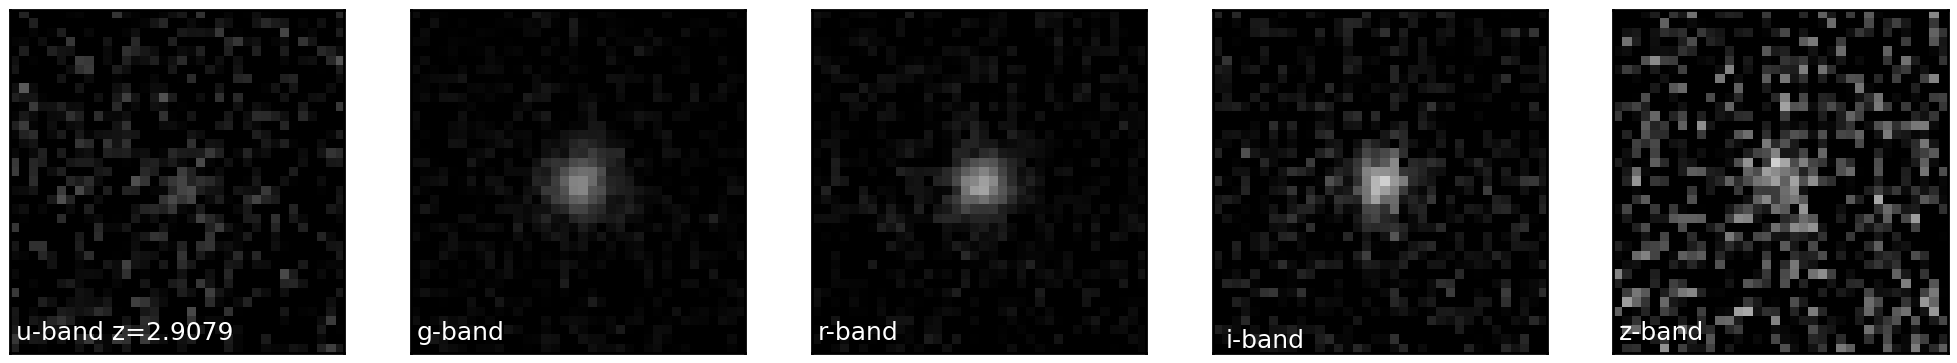

<Table length=1>
       gmag       mt_id_truth_type ...        S2N         ts_redshift
     float64           object      ...      float64         float32  
----------------- ---------------- ... ------------------ -----------
24.47074753188916     8956980301_1 ... 2.1252765722646783     2.91471


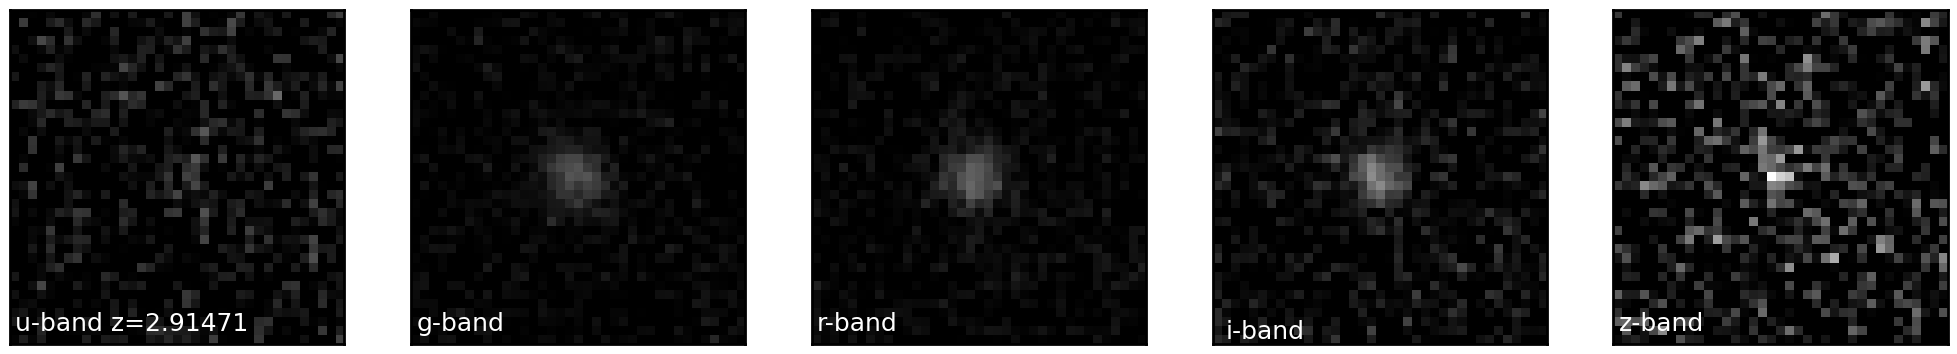

<Table length=1>
       gmag       mt_id_truth_type ...        S2N         ts_redshift
     float64           object      ...      float64         float32  
----------------- ---------------- ... ------------------ -----------
24.44778101081809     8819890090_1 ... 2.4174580071846883     1.73825


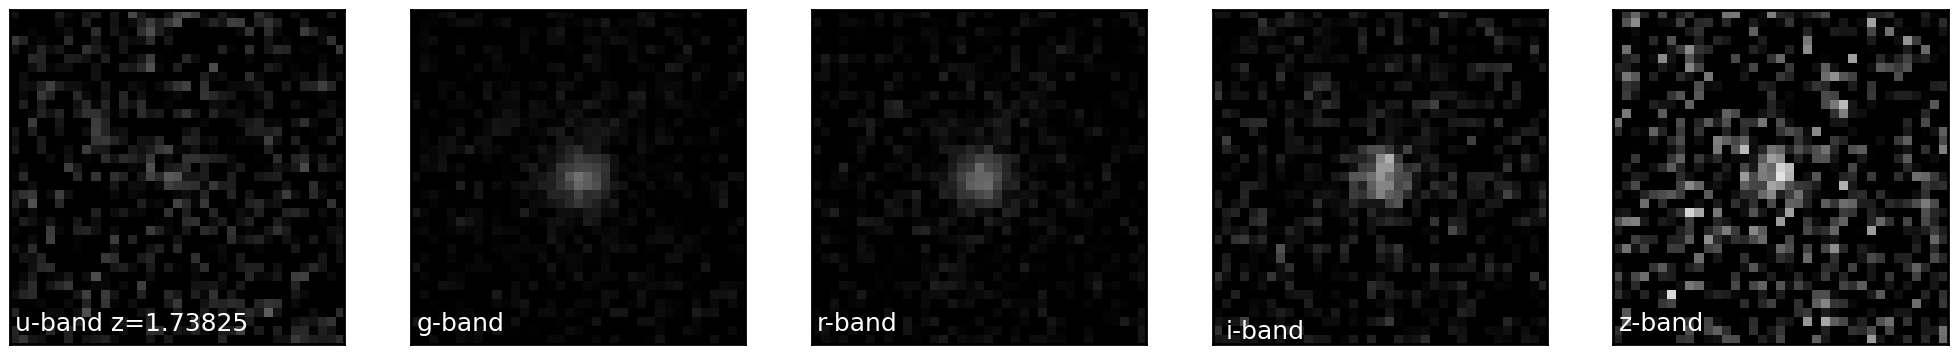

<Table length=1>
       gmag        mt_id_truth_type ...        S2N         ts_redshift
     float64            object      ...      float64         float32  
------------------ ---------------- ... ------------------ -----------
24.481713696132942     8019533337_1 ... 1.9459343443419495      2.8833


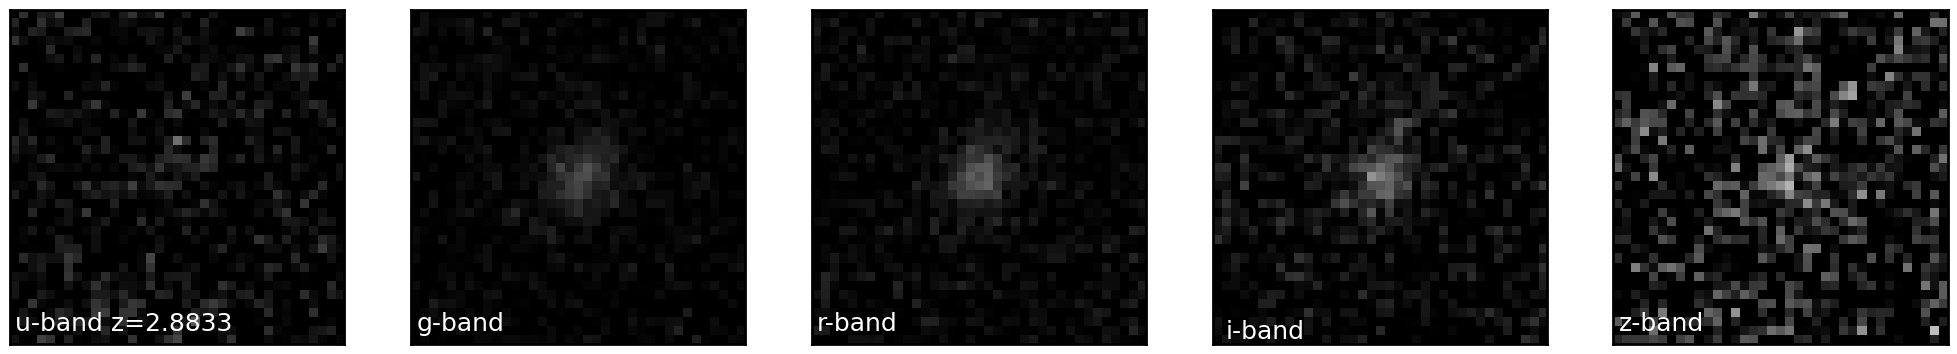

<Table length=1>
       gmag        mt_id_truth_type ...        S2N        ts_redshift
     float64            object      ...      float64        float32  
------------------ ---------------- ... ----------------- -----------
24.218506428303105     7875019846_1 ... 2.972787098916534    0.157679


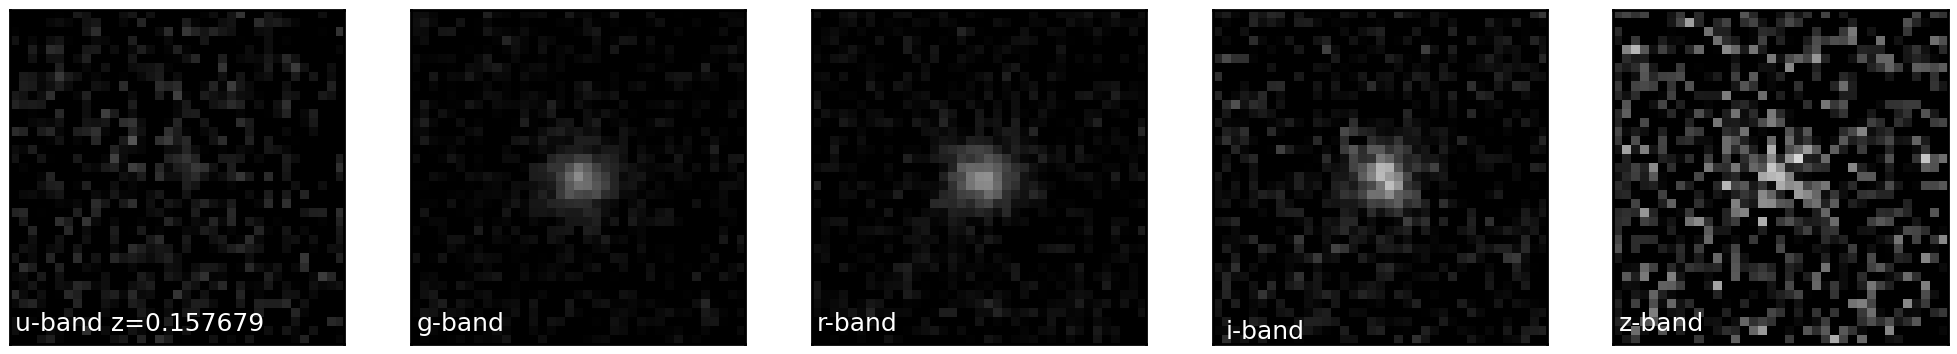

<Table length=1>
       gmag        mt_id_truth_type ...        S2N         ts_redshift
     float64            object      ...      float64         float32  
------------------ ---------------- ... ------------------ -----------
24.447561170142453     8018606732_1 ... 2.3985682630270433     2.82676


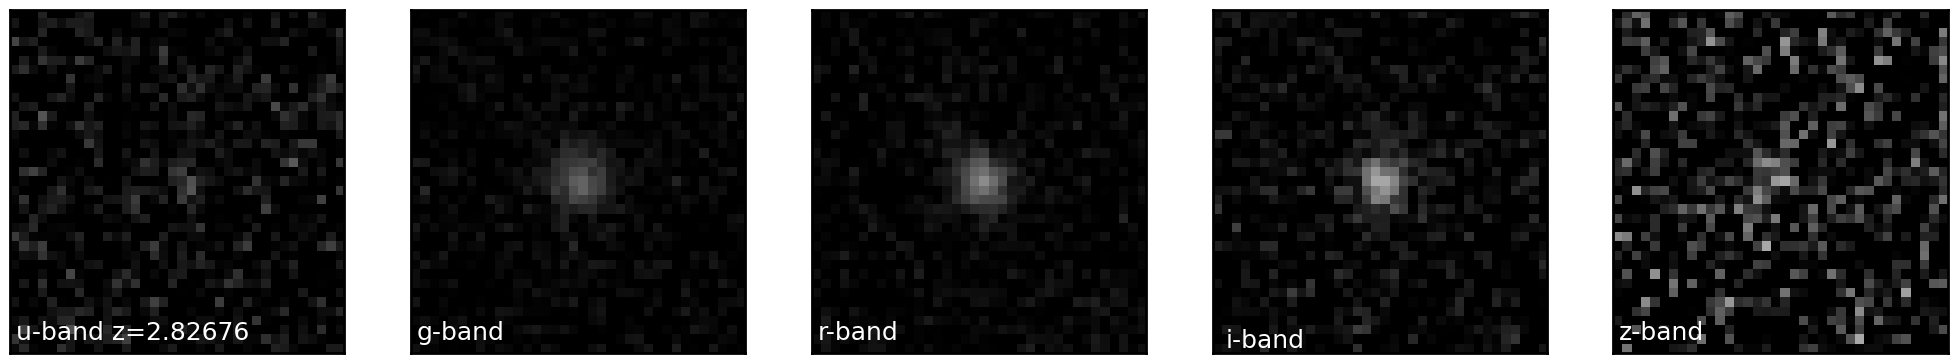

In [21]:

for i in range(5): #len(whlbg)):

    dataId_deep = {'patch':results['patch'][whlbg][i], 'tract':results['tract'][whlbg][i], 'band':'u'}
    testu = make_image_cutout(service, results['coord_ra'][whlbg][i], results['coord_dec'][whlbg][i], 
                              cutout_size=0.001,imtype='deepCoadd', dataId=dataId_deep,filename='cutout_u_'+str(i)+'.fits')
 
    dataId_deep = {'patch':results['patch'][whlbg][i], 'tract':results['tract'][whlbg][i], 'band':'g'}
    testg = make_image_cutout(service, results['coord_ra'][whlbg][i], results['coord_dec'][whlbg][i], 
                              cutout_size=0.001,imtype='deepCoadd', dataId=dataId_deep,filename='cutout_g_'+str(i)+'.fits')

    dataId_deep = {'patch':results['patch'][whlbg][i], 'tract':results['tract'][whlbg][i], 'band':'r'}
    testr = make_image_cutout(service, results['coord_ra'][whlbg][i], results['coord_dec'][whlbg][i], 
                              cutout_size=0.001,imtype='deepCoadd', dataId=dataId_deep,filename='cutout_r_'+str(i)+'.fits')

    dataId_deep = {'patch':results['patch'][whlbg][i], 'tract':results['tract'][whlbg][i], 'band':'i'}
    testi = make_image_cutout(service, results['coord_ra'][whlbg][i], results['coord_dec'][whlbg][i], 
                              cutout_size=0.001,imtype='deepCoadd', dataId=dataId_deep,filename='cutout_i_'+str(i)+'.fits')

    dataId_deep = {'patch':results['patch'][whlbg][i], 'tract':results['tract'][whlbg][i], 'band':'z'}
    testz = make_image_cutout(service, results['coord_ra'][whlbg][i], results['coord_dec'][whlbg][i], 
                              cutout_size=0.001,imtype='deepCoadd', dataId=dataId_deep,filename='cutout_z_'+str(i)+'.fits')


    id = str(results['objectId'][whlbg][i])
    query3 = "SELECT scisql_nanojanskyToAbMag(obj.g_ap09Flux) as gmag, mt.id_truth_type AS mt_id_truth_type, "\
            "obj.objectId AS obj_objectId,  "\
            "obj.u_ap09Flux/obj.u_ap09FluxErr as S2N, "\
           "ts.redshift AS ts_redshift "\
            "FROM dp02_dc2_catalogs.MatchesTruth AS mt "\
            "JOIN dp02_dc2_catalogs.TruthSummary AS ts "\
            "ON mt.id_truth_type=ts.id_truth_type "\
            "JOIN dp02_dc2_catalogs.Object AS obj "\
            "ON mt.match_objectId=obj.objectId "\
            "WHERE obj.objectId="+id+" "\
            "AND ts.truth_type=1 "\
            "AND obj.detect_isPrimary=1 "
            
    results3 = service.search(query3)
    results3.to_table()
    print(results3)
    
    fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize=(25, 25))

    image_file = testu
    hdulist = fits.open(image_file)
    img_hdr = hdulist[1].header
    img_wcs = WCS(img_hdr)
    img_data = fits.getdata(image_file)
    ax1.imshow(img_data, cmap='gray', 
               vmin=0, vmax=0.7, norm='linear',
               origin='lower')
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.text(.1,.9,'u-band z='+str(results3['ts_redshift'][0]),color='white')
    image_file = testg
    img_data = fits.getdata(image_file)
    ax2.imshow(img_data, cmap='gray', 
               vmin=0, vmax=0.7, norm='linear',
               origin='lower')
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.text(.1,.9,'g-band',color='white')
    
    image_file = testr
    img_data = fits.getdata(image_file)
    ax3.imshow(img_data, cmap='gray', 
               vmin=0, vmax=0.7, #norm='linear',
               origin='lower')
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.text(.1,.9,'r-band',color='white')

    image_file = testi
    img_data = fits.getdata(image_file)
    ax4.imshow(img_data, cmap='gray', 
               vmin=0, vmax=0.7, #norm='linear',
               origin='lower')
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax4.text(.9,.1,'i-band',color='white')

    image_file = testz
    img_data = fits.getdata(image_file)
    ax5.imshow(img_data, cmap='gray', 
               vmin=0, vmax=0.7, norm='linear',
               origin='lower')
    ax5.set_xticks([])
    ax5.set_yticks([])
    ax5.text(.1,.9,'z-band',color='white')

    plt.show()


## 4. Creating calexp cutouts to inspect changing flux for the diaObject

Another useful application of the cutout tool is to visually inspect a large number of images of a source identified with difference image analysis (DIA) in order to confirm its variability. 

This example is different in that it requires generating cutouts of calexp files around the time the transient is identified, rather than the deepCoadds as used above. 

### 4.1 Query for the source information needed to plot images before and after the transient event

This example will use a known diaObject with ID 1253478440036730088 (cite where this example came from). The cell below will retrieve the information needed to generate a set of images in order of time, including and after the transient event. The TAP query will identify 100 diaSource IDs measured for this diaObject at the ra/dec, and will also retrieve the ccdVisitId of each time the diaSource was observed in a calexp image.  



In [22]:
# random DIAobject from a testing code (this ra/dec don't work for some reason
#ra = 72.5383603
#dec = -44.4248533
diaObjectId =  1250830816037045527 #1253478440036730088
# Jeff used: 1250953961339360185

# find the source by matching the source ID, which gives you the exact source
#query = "SELECT TOP " + str(100) + " " + \
#        "diaObjectId, ra, decl, coord_ra, coord_dec, ccdVisitId " + \
#        "FROM dp02_dc2_catalogs.DiaSource " + \
#        "WHERE diaObjectId = " + str(diaObjectId) + " "

# can get filter and MJD from diasource? If so, then maybe you don't have to do the next cell search
# ccdVisitId = visitid+detector where detector starts with 001
# or could join on ccdVisitId (check if this is an optioN).

#print(diaObjectId)
#visits = service.search(query)
#my_tab = visits.to_table()#.to_pandas()

# adding cols to pandas tables should be straitforward
# should be able to join the diasource with ccdvisitid tables. join on ccdvisitid 
# adql functionality join will do it. see notebook 02.

In [23]:
# maybe, instead, use Jeff's join query:
# do we need to sort out diaObjectId vs diaSourceId

#ccdquery = "SELECT TOP 10 dia.coord_ra, dia.coord_dec, " + \
#                        "dia.diaObjectId,  dia.ccdVisitId, dia.band, " + \
#                        "cv.visitId, cv.physical_filter, cv.detector, cv.obsStartMJD, " + \
#                         "cv.expMidptMJD " + \
#                         "FROM dp02_dc2_catalogs.ForcedSourceOnDiaObject as dia " + \
#                         "JOIN dp02_dc2_catalogs.CcdVisit as cv ON cv.ccdVisitId = dia.ccdVisitId " + \
#                         "WHERE dia.diaObjectId = "+str(diaObjectId)+" AND cv.band = 'i'"

results = service.search("SELECT fsodo.coord_ra, fsodo.coord_dec, "\
                         "fsodo.diaObjectId, fsodo.ccdVisitId, fsodo.band, "\
                         "fsodo.psfDiffFlux, fsodo.psfDiffFluxErr, "\
                         "fsodo.psfFlux, fsodo.psfFluxErr, "\
                         "cv.visitId, cv.physical_filter, cv.detector, cv.obsStartMJD, " + \
                         "cv.expMidptMJD "\
                         "FROM dp02_dc2_catalogs.ForcedSourceOnDiaObject as fsodo "\
                         "JOIN dp02_dc2_catalogs.CcdVisit as cv ON cv.ccdVisitId = fsodo.ccdVisitId "\
                         "WHERE fsodo.diaObjectId = "+str(diaObjectId))

#diaccdsearch = service.search(results)
forcedSrc = results.to_table()
forcedSrc
#del diaccdsearch

coord_ra,coord_dec,diaObjectId,ccdVisitId,band,psfDiffFlux,psfDiffFluxErr,psfFlux,psfFluxErr,visitId,physical_filter,detector,obsStartMJD,expMidptMJD
deg,deg,,,,nJy,nJy,nJy,nJy,,,,,d
float64,float64,int64,int64,object,float64,float64,float64,float64,int64,object,int64,float64,float64
60.368959,-44.582947,1250830816037045527,1013712023,i,8275.0773352,551.7155499,41828.2301457,549.1341275,1013712,i_sim_1.4,23,61076.1387726,61076.1389462
60.368959,-44.582947,1250830816037045527,975987147,g,31.1275999,88.4383943,3016.0756055,82.4205356,975987,g_sim_1.4,147,61017.0916576,61017.0918312
60.368959,-44.582947,1250830816037045527,1217176167,i,86.3027656,297.8830014,9774.6167851,304.1591798,1217176,i_sim_1.4,167,61371.2738726,61371.2740462
60.368959,-44.582947,1250830816037045527,943428001,r,138.9036456,204.0933762,11762.1596729,202.7694829,943428,r_sim_1.4,1,60961.2970666,60961.2972402
60.368959,-44.582947,1250830816037045527,1002925146,z,8610.7234322,685.0395705,38585.2636163,664.3315707,1002925,z_sim_1.4,146,61062.0375136,61062.0376872
60.368959,-44.582947,1250830816037045527,1157610018,i,178.8453231,290.5014775,23017.2171541,285.7729459,1157610,i_sim_1.4,18,61274.3619726,61274.3621462
60.368959,-44.582947,1250830816037045527,1187409157,u,32.6467282,253.9043064,1378.8443798,239.0434495,1187409,u_sim_1.4,157,61321.1746016,61321.1747752
60.368959,-44.582947,1250830816037045527,939191051,z,-775.0407488,652.5322427,22252.4153232,627.5790786,939191,z_sim_1.4,51,60956.2651916,60956.2653652


In [24]:
# this isn't going to work because you're not grabbing the source at its transient 
# phase. you have to do the second search that Jeff did to fidn out when its going boom.
#ccdvisitId table has expMidptMJD 	double 	d 	Midpoint for exposure in MJD. TAI, accurate to 10ms.
max = np.max(forcedSrc['psfFlux'])
whmax = np.where((forcedSrc['psfFlux'] == np.max(forcedSrc['psfFlux'])))[0]
x = forcedSrc['expMidptMJD']
print(whmax, x[whmax])

whtimeatmax = np.where(forcedSrc['expMidptMJD'] > x[whmax])[0]
wh = np.argsort(forcedSrc['expMidptMJD'][whtimeatmax]) #['obsStartMJD'])
forcedSrc[whtimeatmax][wh]
#forcedSrc['detector'][wh]

[31]  expMidptMJD 
      d      
-------------
61100.0701512


coord_ra,coord_dec,diaObjectId,ccdVisitId,band,psfDiffFlux,psfDiffFluxErr,psfFlux,psfFluxErr,visitId,physical_filter,detector,obsStartMJD,expMidptMJD
deg,deg,,,,nJy,nJy,nJy,nJy,,,,,d
float64,float64,int64,int64,object,float64,float64,float64,float64,int64,object,int64,float64,float64
60.368959,-44.582947,1250830816037045527,1033109168,y,-1299.8299774,1512.811107,55916.8032516,1498.5709964,1033109,y_sim_1.4,168,61101.0643246,61101.0644982
60.368959,-44.582947,1250830816037045527,1033112104,y,104.845331,1543.3379061,58481.4468598,1505.3894249,1033112,y_sim_1.4,104,61101.0656636,61101.0658372
60.368959,-44.582947,1250830816037045527,1033987077,y,370.57267,1760.9477241,72216.7148856,1726.8022637,1033987,y_sim_1.4,77,61102.0682906,61102.0684642
60.368959,-44.582947,1250830816037045527,1038221184,r,2042.579589,163.3259681,11420.4130034,158.403557,1038221,r_sim_1.4,184,61107.0510556,61107.0512292
60.368959,-44.582947,1250830816037045527,1038222165,r,--,--,10692.840277,152.5798011,1038222,r_sim_1.4,165,61107.0515006,61107.0516742
60.368959,-44.582947,1250830816037045527,1038223001,r,1973.1746729,161.9730493,11467.3422877,157.6821863,1038223,r_sim_1.4,1,61107.0519506,61107.0521242
60.368959,-44.582947,1250830816037045527,1039023037,y,-839.6275702,1108.9757258,39530.6643303,1095.1970074,1039023,y_sim_1.4,37,61108.0187886,61108.0189622
60.368959,-44.582947,1250830816037045527,1039915110,g,-174.7318464,138.2022393,6966.6755316,132.7821717,1039915,g_sim_1.4,110,61109.0272446,61109.0274182


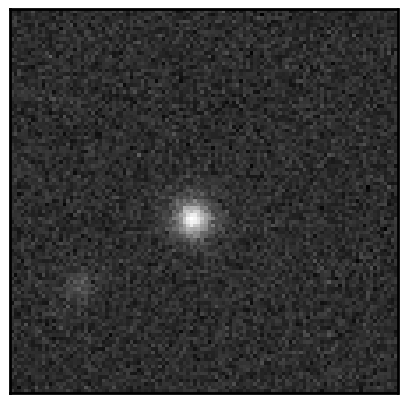

In [28]:
%matplotlib inline
# This cell plots the cutouts by order of MJD 
#def make_image_cutout(butler, tap_service, ra, dec, cutout_size=0.01, imtype=None, visit=None, detector=None, filename=None):
ra = forcedSrc['coord_ra']
dec = forcedSrc['coord_dec']

for i in range(1):
    dataId_calexp = {'visit':forcedSrc['visitId'][whtimeatmax][wh][i], 'detector':forcedSrc['detector'][whtimeatmax][wh][i]}
    test = make_image_cutout(service, ra[whtimeatmax][wh][i], dec[whtimeatmax][wh][i], cutout_size=0.003,imtype='calexp', dataId=dataId_calexp,
                             filename='cutout_'+str(i)+'.fits')
                             #visit=forcedSrc['visitId'][wh][i], detector=forcedSrc['detector'][wh][i])

    #fig, ax = plt.subplots()
    #display = afwDisplay.Display(frame=fig)
    #display.scale('asinh', 'zscale')
    #display.mtv(ExposureF(test))
    #plt.show()
    #plotImage(ExposureF(test))
    ref_fitsname = 'cutout_'+str(i)+'.fits'
    image_file = os.path.join(os.getenv('HOME'), 'temp/'+ref_fitsname)

    fig, ax1 = plt.subplots(1,1, figsize=(5, 5))

    hdulist = fits.open(image_file)
    img_hdr = hdulist[1].header
    img_wcs = WCS(img_hdr)
    img_data = fits.getdata(image_file)
    ax1.imshow(img_data, cmap='gray', 
               #vmin=0, vmax=0.7, norm='linear',
               origin='lower')
    ax1.set_xticks([])
    ax1.set_yticks([])
    plt.show()


instead of grayscale, use matplotlib virdis to see if that enhances the transient

 coord_ra coord_dec      diaObjectId     ...  obsStartMJD   expMidptMJD 
   deg       deg                         ...                     d      
--------- ---------- ------------------- ... ------------- -------------
60.368959 -44.582947 1250830816037045527 ... 61259.3242006 61259.3243742
60.368959 -44.582947 1250830816037045527 ... 61319.3843766 61319.3845502
60.368959 -44.582947 1250830816037045527 ... 61373.2491616 61373.2493352
60.368959 -44.582947 1250830816037045527 ... 61334.1518166 61334.1519902
60.368959 -44.582947 1250830816037045527 ... 61338.2422566 61338.2424302
60.368959 -44.582947 1250830816037045527 ... 61098.0851396 61098.0853132
60.368959 -44.582947 1250830816037045527 ... 61321.1746016 61321.1747752
60.368959 -44.582947 1250830816037045527 ... 59975.1676536 59975.1678272
60.368959 -44.582947 1250830816037045527 ... 61003.0656876 61003.0658612
60.368959 -44.582947 1250830816037045527 ... 61325.2056506 61325.2058242
      ...        ...                 ... ...       

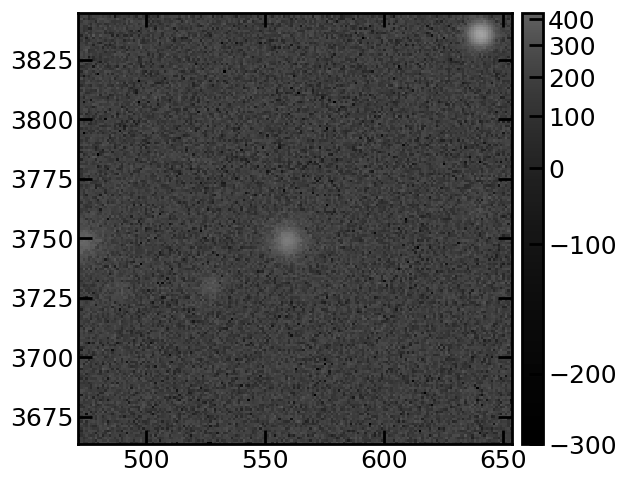

0.005
cutout_1.fits


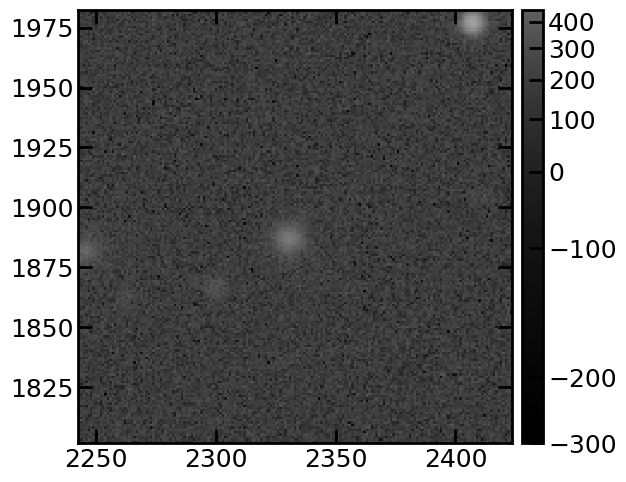

0.005
cutout_2.fits


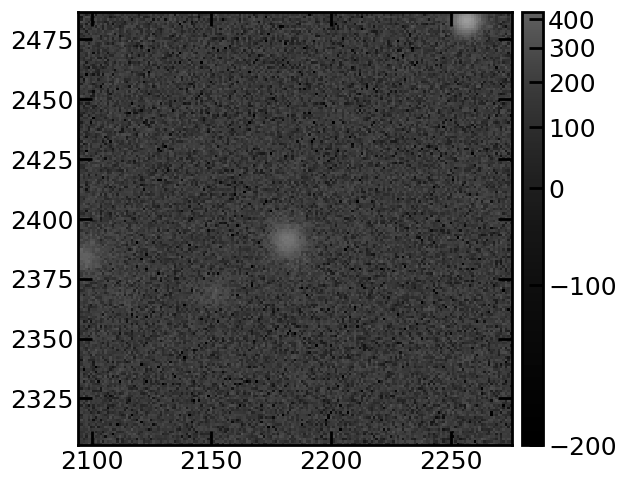

0.005
cutout_3.fits


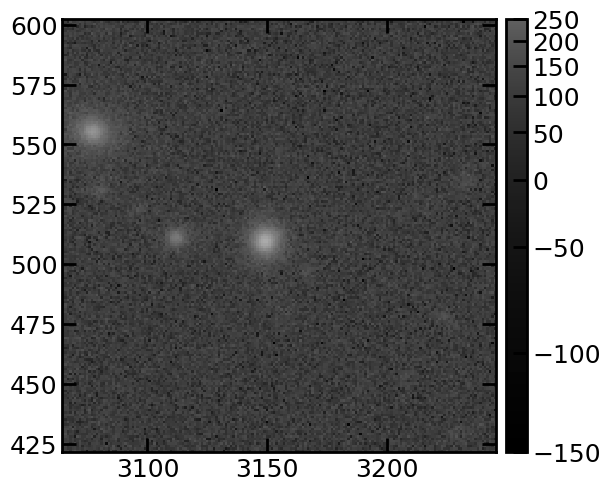

0.005
cutout_4.fits


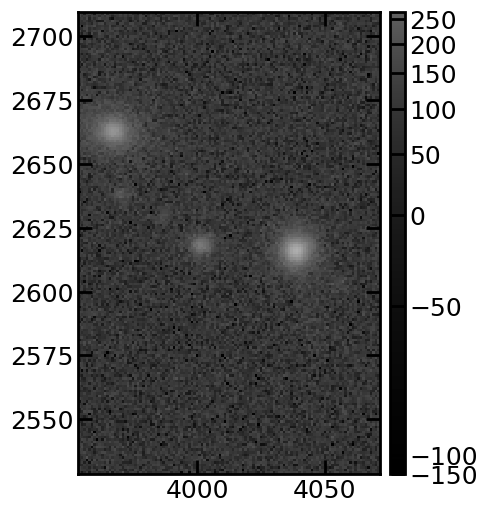

0.005
cutout_5.fits


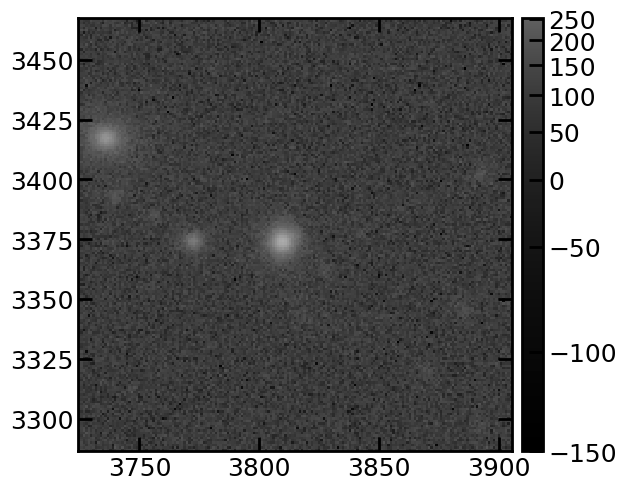

0.005
cutout_6.fits


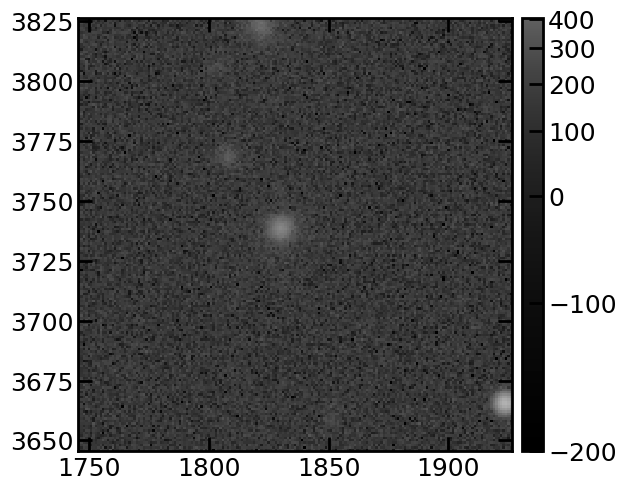

0.005
cutout_7.fits


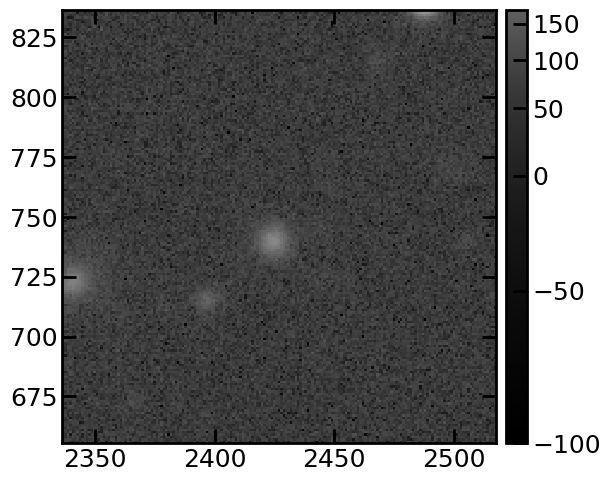

0.005
cutout_8.fits


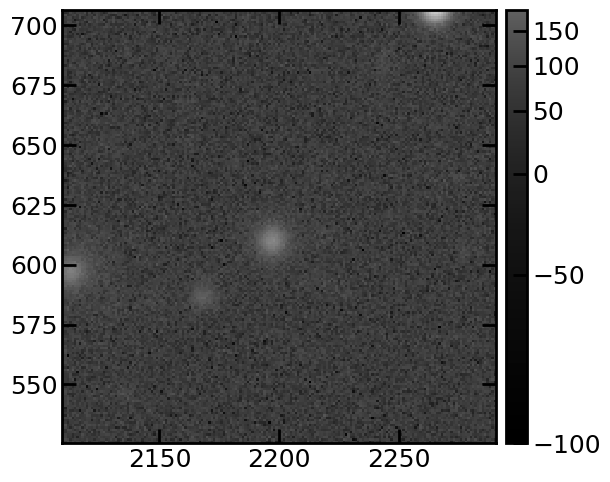

0.005
cutout_9.fits


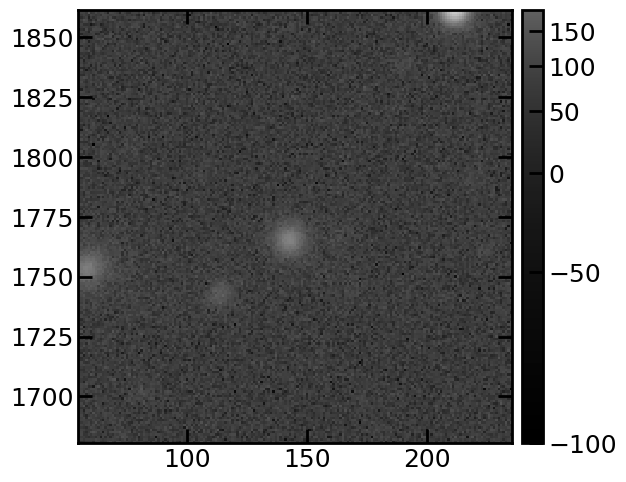

0.005
cutout_10.fits


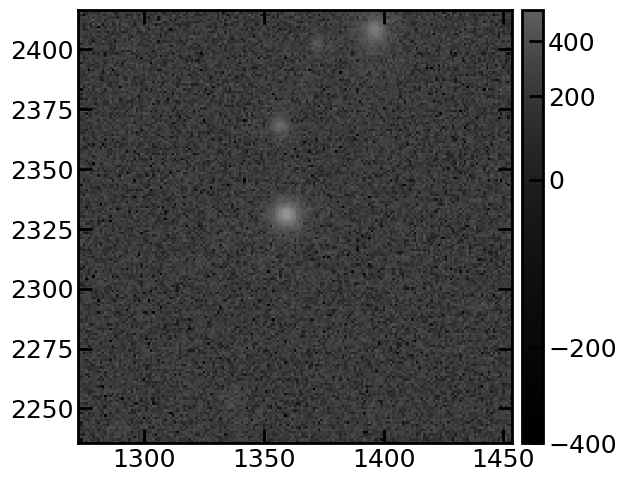

0.005
cutout_11.fits


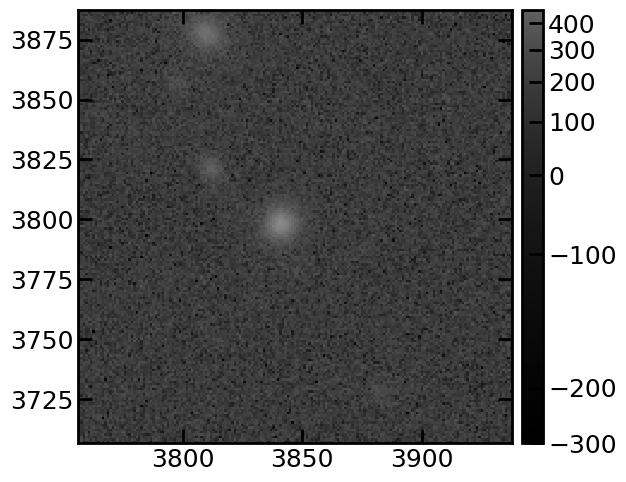

0.005
cutout_12.fits


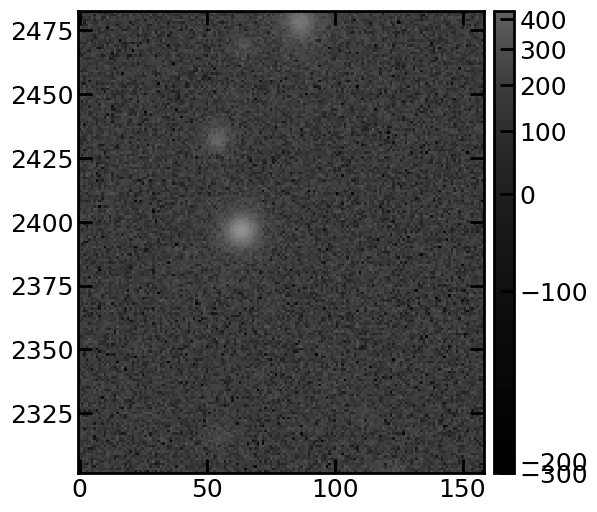

0.005
cutout_13.fits


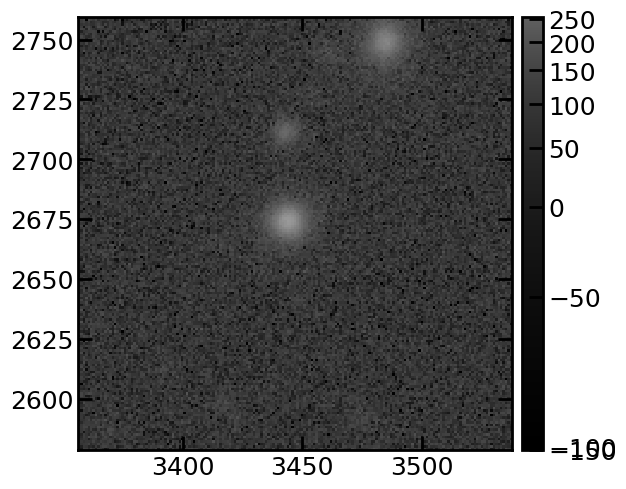

0.005
cutout_14.fits


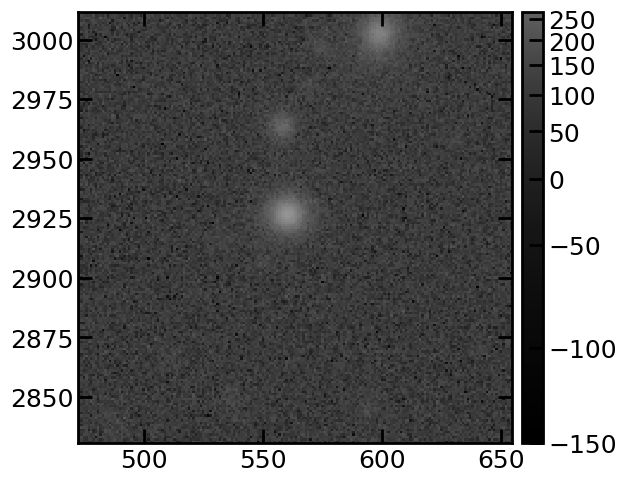

0.005
cutout_15.fits


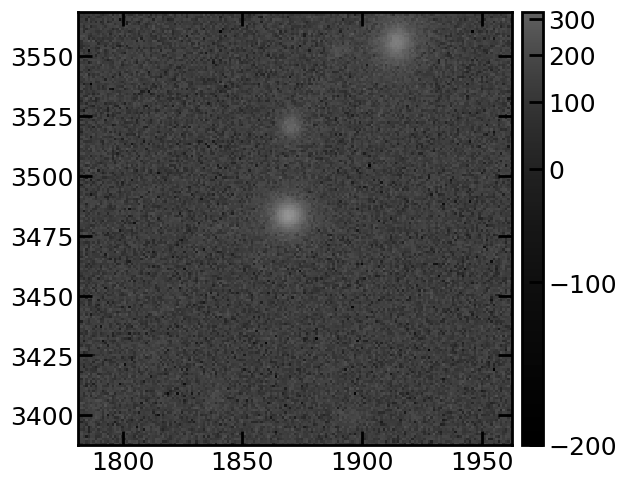

0.005
cutout_16.fits


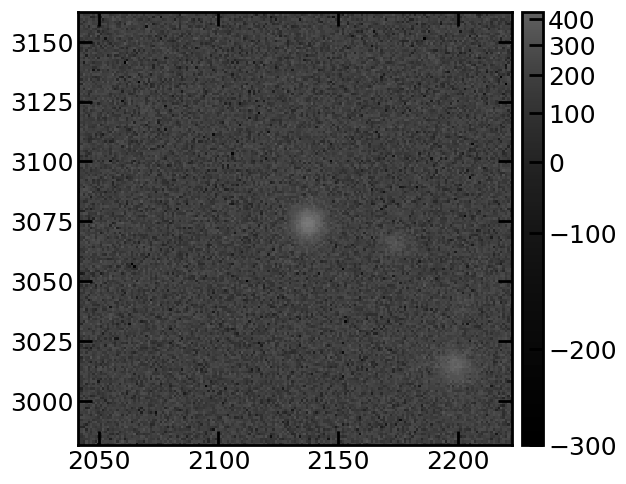

0.005
cutout_17.fits


FitsError: 
  File "src/fits.cc", line 1594, in lsst::afw::fits::Fits::Fits(const string&, const string&, int)
    cfitsio error: error reading from FITS file (108) : Opening file '/home/christinawilliams/temp/cutout_17.fits' with mode 'r'
cfitsio error stack:
  ffgcnn could not find column: ZSCALE
  ffgcnn could not find column: ZZERO
  ffgcnn could not find column: ZSCALE
  ffgcnn could not find column: ZZERO
  ffgcnn could not find column: ZSCALE
  ffgcnn could not find column: ZZERO
  ffgcnn could not find column: ZSCALE
  ffgcnn could not find column: ZZERO
  ffgcnn could not find column: ZSCALE
  ffgcnn could not find column: ZZERO
  ffgcnn could not find column: ZSCALE
  ffgcnn could not find column: ZZERO
  ffgcnn could not find column: ZSCALE
  ffgcnn could not find column: ZZERO
  ffgcnn could not find column: ZSCALE
  ffgcnn could not find column: ZZERO
  ffgcnn could not find column: ZSCALE
  ffgcnn could not find column: ZZERO
  ffgcnn could not find column: ZSCALE
  Error reading data buffer from file:
  /home/christinawilliams/temp/cutout_17.fits
  ffopen could not interpret primary array header of file: 
  /home/christinawilliams/temp/cutout_17.fits
 {0}
lsst::afw::fits::FitsError: 'cfitsio error: error reading from FITS file (108) : Opening file '/home/christinawilliams/temp/cutout_17.fits' with mode 'r'
cfitsio error stack:
  ffgcnn could not find column: ZSCALE
  ffgcnn could not find column: ZZERO
  ffgcnn could not find column: ZSCALE
  ffgcnn could not find column: ZZERO
  ffgcnn could not find column: ZSCALE
  ffgcnn could not find column: ZZERO
  ffgcnn could not find column: ZSCALE
  ffgcnn could not find column: ZZERO
  ffgcnn could not find column: ZSCALE
  ffgcnn could not find column: ZZERO
  ffgcnn could not find column: ZSCALE
  ffgcnn could not find column: ZZERO
  ffgcnn could not find column: ZSCALE
  ffgcnn could not find column: ZZERO
  ffgcnn could not find column: ZSCALE
  ffgcnn could not find column: ZZERO
  ffgcnn could not find column: ZSCALE
  ffgcnn could not find column: ZZERO
  ffgcnn could not find column: ZSCALE
  Error reading data buffer from file:
  /home/christinawilliams/temp/cutout_17.fits
  ffopen could not interpret primary array header of file: 
  /home/christinawilliams/temp/cutout_17.fits
'


In [29]:
# Jeff's code to generate a gif

print(forcedSrc[wh])
#coord_ra	coord_dec	diaObjectId	ccdVisitId	band	visitId	physical_filter	detector	obsStartMJD	expMidptMJD

ii = 0
i = 0
cutout_size_pix = 131

#sys.exit()
#for src in forcedSrc[wh]:#diaSrc:
for i in range(len(wh)):
    visit=forcedSrc['visitId'][whtimeatmax][wh][i]
    detector=forcedSrc['detector'][whtimeatmax][wh][i]
    #ccdvisitID = src['ccdVisitId']
    #visit = str(ccdvisitID)[:-3]
    #detector = str(ccdvisitID)[-3:]
    #visit = int(visit)
    #detector = int(detector)
    dataId_calexp = {'visit':visit, 'detector':detector}
    if i == 0:
        # 0.2-arcsec pixels, convert to degrees
        cutout_size = .005#(cutout_size_pix*2) * 0.2/3600.0
        print(cutout_size)
        
        # Make the first image the reference image that we'll warp all the others to.
        ref_fitsname = 'cutout_ref.fits'
        ref_cutout = os.path.join(os.getenv('HOME'), 'temp/'+ref_fitsname)
        print(ra[whtimeatmax][wh][i],dec[whtimeatmax][wh][i])
        make_image_cutout(service, ra[whtimeatmax][wh][i], dec[whtimeatmax][wh][i], cutout_size=cutout_size, imtype='calexp',
                          dataId=dataId_calexp, filename=ref_fitsname)
        img_ref = ExposureF(ref_cutout)
        plotImage(img_ref) #this works for plotting
        
        # PICK vmin and vmax based on the reference image for use later
        vmin = -200
        vmax = 300
        
        
    else:
        cutout_size = .005#(cutout_size_pix*1.1) * 0.2/3600.0
        print(cutout_size)
    #ii += 1

        fitsname = 'cutout_'+str(i)+'.fits'
        print(fitsname)
        make_image_cutout(service, ra[whtimeatmax][wh][i], dec[whtimeatmax][wh][i], cutout_size=cutout_size, imtype='calexp',
                          dataId=dataId_calexp, filename=fitsname)
        img_cutout = os.path.join(os.getenv('HOME'), 'temp/'+fitsname)
        img = ExposureF(img_cutout)
        
        plotImage(img) #this works for plotting
    
    
        img_warped = warp_img(img_ref, img, img_ref.getWcs(), img.getWcs())
        
        fig, ax = plt.subplots()
    
        ### CAN AN ERROR BE HERE WITH CUTOUT_SIZE_PIX?
        minmax = get_minmax_xy(img_warped, cutout_size_pix)
    
        # maybe somehting is wrong with the bounding box here. Try removing warped and see if the gif works?
        im_arr = img_warped.image.array[minmax['minx']:minmax['maxx'], minmax['miny']:minmax['maxy']]
        im_arr_bgnorm = im_arr#/np.nanmedian(im_arr)
        
        # Create an ImageNormalize object
        #norm = ImageNormalize(im_arr_bgnorm, interval=ZScaleInterval(),
        #                      stretch=LinearStretch())
        
        plt.imshow(im_arr, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)#norm=norm, 
    
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
        #plt.title('MJD: '+str(src['midPointTai'])+'; band: '+str(src['filterName']))
        figname = os.path.join(os.getenv('HOME'), 'temp/cutout_'+str(i)+'.png')
        if os.path.isfile(figname):
            os.remove(figname)
        #plt.show()
        plt.savefig(figname)
        plt.close()
    



In [ ]:
from IPython.display import Image as dimg

images = os.path.join(os.getenv('HOME'), 'temp/')
make_gif(images)

display(dimg(data=open(images+'animation.gif','rb').read()))#, format='png'))

#imdisp(images+'animation.gif')
#sys.exit()

In [ ]:
# Now, delete all files
os.remove(temp/*fits)

notes with melissa:
still TBD:
- demonstrate a failure case
- we dont' yet have a tutorial on galaxy measurements: maybe some sample non-deblended with a larger diversity of shapes and overplot the morph (semi major/minor ellipsoid)

- ask leanne to review with specific focus on technical part and then get a CST reviewer like jeff for the science case

## Junk code

In [ ]:
# Testing various ways to skip writing to disk here (not working):

#plotImage(ExposureF(sodaCutout))
#plotImage(ExposureF(sq.execute_stream()))

# THIS DOES NOT WORK, and times out after IOPub data rate exceeded:
#x = sq.execute_stream().read()
#print(x)

#image_url = dl_results.getrecord(0).get('access_url')
#plotImage(ExposureF(image_url))
#plotImage(ExposureF(sq))

# This does not work to pass the cutout without saving
#fig = plt.figure()
#display = afwDisplay.Display(frame=fig)
#display.scale('asinh', 'zscale')
#display.mtv(test)
#plt.show()

In [ ]:
# ccdvisittable is a separate catalog that contains all observations and I could use that to extract further info. 
# get detector and visit from ccdvisittable using ccdvisitid. 

ccdqu = "SELECT "  + \
        "ccdVisitId, visitId, physical_filter, band, detector, obsStartMJD " + \
        "FROM dp02_dc2_catalogs.CcdVisit " + \
        "WHERE ccdVisitId = " + str(visits['ccdVisitId'][0]) + " "

# here you have to search on band
# could also return all bands so that you plot all r band and all i band etc sorted by mjd.
# make a colored outline or label the filter int he cutout or something.
# or, chronological order for 1 filter
# user case: want to see if any of the images are bad and so see 

ccdvisit = service.search(ccdqu)
ccdvisit.to_table().to_pandas()
print(ccdvisit)

my_tab['test'] = np.zeros(len(ccdvisit))

In [ ]:
# Write a loop to add these values into one table, so that we can then sort by MJD
# visits = DiaObjs
#print(visits, len(visits))
my_tab['MJD'] = np.zeros(len(visits), dtype='float')
#visits.assign(MJD=0).head()
my_tab['visit'] = np.zeros(len(visits), dtype='float')
my_tab['ccdVisitId_test'] = np.zeros(len(visits), dtype='float')
my_tab['detector'] = np.zeros(len(visits), dtype='float')
my_tab['band'] = np.zeros(len(visits), dtype='float')

# Specify the calexp that we are accessing
#dataId = {'visit': 192350, 'detector': 175, 'band': 'i'}
# Retrieve the data using the `butler` instance and its function `get()`
#calexp = butler.get('calexp', **dataId)


#dont' forget to check Melissa's test NB about imaging in slack
for j in enumerate(visits['ccdVisitId']):
    #print(j)
    ccdqu = "SELECT "  + \
        "ccdVisitId, visitId, physical_filter, band, detector, obsStartMJD " + \
        "FROM dp02_dc2_catalogs.CcdVisit " + \
        "WHERE ccdVisitId = " + str(j[1]) + " " # AND band = 'r' ?
    ccdvisit = service.search(ccdqu).to_table().to_pandas()
    #print(ccdvisit['band'])

    #FSDiaObj['expMidptMJD'][i[0]]=results['expMidptMJD'][0]
    #print(ccdvisit['obsStartMJD'])
    my_tab['MJD'][j[0]] = ccdvisit['obsStartMJD'][0]
    my_tab['visit'][j[0]] = ccdvisit['visitId'][0]
    #my_tab['band'][j[0]] = ccdvisit['band'][0]
    #my_tab['ccdVisitId_test'][j[0]] = ccdvisit['ccdVisitId'][0]
    my_tab['detector'][j[0]] = ccdvisit['detector'][0]
    

    #del ccdvisit


In [ ]:
# junk code
#"FROM dp02_dc2_catalogs.ForcedSource as source "\
#        "JOIN dp02_dc2_catalogs.Object as obj ON source.objectId = obj.objectId "\

# here you will need to also set all U-mags with S/N < 1 to the 1-sig error.
# another idea is to join to MatchesTruth table on matchObjectId and then use id of the matches to join
# on TruthSummary to get redshift

# this appears to select things i want
#query = "SELECT TOP " + str(max_rec) + " " + \
#        "objectId, coord_ra, coord_dec, detect_isPrimary, patch, tract, " + \
#        "u_kronFlux, scisql_nanojanskyToAbMag(u_kronFlux) as umag, scisql_nanojanskyToAbMag(r_kronFlux) as rmag, scisql_nanojanskyToAbMag(g_kronFlux) as gmag " + \
#        "FROM dp02_dc2_catalogs.Object " + \
#        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
#        "CIRCLE('ICRS', " + use_center_coords + ", " + use_radius + ")) = 1 " + \
#        "AND detect_isPrimary = 1 " + \
#        "AND g_kronFlux/g_kronFluxErr > 10 AND r_kronFlux/r_kronFluxErr > 10" + \
#        "AND scisql_nanojanskyToAbMag(g_kronFlux) < 26 " 
##        "AND g_kronFlux/g_kronFluxErr > 10 " + \

#if os.path.exists('$HOME/temp'):
#    print('temp/ directory already exists')
#else:
#    os.mkdir('$HOME/temp')
#    print('Made a temp/ directory')

#if os.path.exists('images'):
#    print('images/ directory already exists')
#else:
#    os.mkdir('images')
#    print('Made an images/ directory')



## meeting with Leanne 6/1/23
Look at the sodaquery API to figure out what the format the sq is in. also can type help(sq)
maybe try doing holoviews streaming data instead execute_stream (or execute_raw) or streamz library in holoviews
look at the matplotlib API to see if you can feed it the sq (tried this, doesnt work). for now just write things to file, and proceed with science application. we will revisit plotting directly the image after talkign to DM at the next data reveiw(??) 

## questions from Melissa
 how can we show failure modes (i.e. if you make a cutout near the boundary) or max sizes on the cutout?
 maybe that goes in Leanne's notebooK? we should test what happens

get a SN near a host galaxy so looks interesting
real science use cases: lensed SN (short time delay with multiple images) when seeing is bad the sources may be blended, and if seeing is good they are deblended. people will lok for DIAobjects close togehter because they might be the same physical thing. Source association pipeline split into multiple ones in cases like this. Ryan-this has already happened (2 DIAobj close to same position and some images will have some sources and other images will have other sources identified. Now you can plot all the
 cutouts (2-4" of eachother). DP0.2 doesnt' have lensed transients so just pick nearby DIAobjs as a demonstrated failure mode which is a good use case. ask Ryan about this (ticket open to explore source association for DIAobj) users can get seeing out of the catalogs (check schema in DIAsource catalog, measurement of PSF? ccdvisit table has it for the whole visit

 another failure mode using variable stars close together maybe seeing differences between visits get blended but maybe SN science app is better. 
 
Ask leanne why we need both butler and tap service to do this (can we get either UUID or datalink from one or the other?)

### questions for melissa 4/26:
### - if you want to have a function that uses a butler instance what is the best way to do that?

## From Melissa 4/26:
 we want to avoid having users write things. See if you can do this without
 writing the file to disk. then you can show an example of how to do that
 but in general we want people not to that
 what is function ExposureF? Does F stand for file?



### Answers for Melissa 4/30/23: 
Yes, F stands for file and this tries to open the file written to disk.

To ask Leanne: is this needed? I only see dataurl for the entire image but can the cutout be stored in memory and not written to disk? Also ask: why isn't the circle cutout actually a circle? Why does polygon also let you define a triangle but also returns a rectangle?

To ask Jeff: did he find this slow (is it because reading/writing files?)
Since the visit and detector are required inputs for the calexp case, it might be good to add a try/except block to make sure they’re provided whenever a  calexp cutout is requested.
Since the visit and detector are required inputs for the calexp case, it might be good to add a try/except block to make sure they’re provided whenever a  calexp cutout is requested.


dm_rsp slack channel (soda is a service in RSP).
also could look in NOIRLab datalab because they have some soda tutorials. they might have more info on 
the format of soda returns. also can see who wrote the datalab notebook and see who wrote it and go talk in person.

look at the datalab and see what the use cases they have for sodaqueries or cutouts. 

if doing gif, could do side by side direct image and difference image gifs (run at the same time one is direct image one is difference image). fix the scaling so you can visualize the brihgtness. another application: search object catalog for a bunch of galaxies that had weird shape measurements and look at them all because you're gonna pass them to a citizen science or run galfit on them. 50x50 mosaic of a bunch of weird galaxies. could order them something (color?) and make RGB for differnet cutouts (look in notebook 3a for RGB) 



From melissa 11/27

hardwire the deleting of cutouts as part of the cleanup
as you develop final steps of notebook start using weekly 47 

switch order so deep coadds first and then the calexp demonstration.
Have notebook make a temp directory 
$HOME/temp and everything should be written thereat the end delete contents and directory itselftutorials notebook repo directory will be read only.

Notes to self as of 12/1/23:
Wanted to do a join search including data from truth tables but something weird happened (without the join, I get things that resemble color-selected LBG. With, I got objects that are at z=0). Perhaps test pulling out the truth value specifically for the LBGs after having used your query (notebook 8's step 3.3), not Jeffs? Not sure I understand why you have to do the intermediate step of matching on 

From Melissa 12/21
look in custom coadd tutorial
ExposureF is an image type that the butler uses
Melissa suggests using this example:
https://github.com/rubin-dp0/little-demos/blob/main/api_from_noirlab.ipynb
the urlretrieve function might write out a standard fits file you can then open using matplotlib instead of ExposureF and PlotImage
